In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [22]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))  # change lr from 0.001 (default) to 0.0001

In [23]:
model_version_old = "0.0.0.5"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

Epoch 11520/11520 (last)
505/505  - 6s 11ms/step - loss: 413.7224 - reconstruction_loss: 412.1891 - kl_loss: 1.5333

In [25]:
history_callback = vae.fit(x_train, epochs=50 * batch_size, batch_size=batch_size)

model_version = "0.0.0.7_lr0.0001_50moreepochs"
os.system('mkdir ' + base_dir + '/weights' + model_version)

vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.4468 - reconstruction_loss: 411.9109 - kl_loss: 1.5359
Epoch 2/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.4614 - reconstruction_loss: 411.9249 - kl_loss: 1.5365
Epoch 3/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.4136 - reconstruction_loss: 411.8771 - kl_loss: 1.5365
Epoch 4/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.4403 - reconstruction_loss: 411.9039 - kl_loss: 1.5364
Epoch 5/6400
505/505 [==============================] - 5s 11ms/step - loss: 413.4577 - reconstruction_loss: 411.9211 - kl_loss: 1.5366
Epoch 6/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.4231 - reconstruction_loss: 411.8856 - kl_loss: 1.5375
Epoch 7/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.4275 - reconstruction_loss: 411.8905 - kl_loss: 1.5370
Epoch 8/6400
505/505 [==========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3278 - reconstruction_loss: 411.7841 - kl_loss: 1.5436
Epoch 61/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3494 - reconstruction_loss: 411.8061 - kl_loss: 1.5433
Epoch 62/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3059 - reconstruction_loss: 411.7620 - kl_loss: 1.5439
Epoch 63/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3389 - reconstruction_loss: 411.7947 - kl_loss: 1.5442
Epoch 64/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3398 - reconstruction_loss: 411.7963 - kl_loss: 1.5436
Epoch 65/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3671 - reconstruction_loss: 411.8228 - kl_loss: 1.5443
Epoch 66/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3567 - reconstruction_loss: 411.8129 - kl_loss: 1.5438
Epoch 67/6400
505/505 [==============================] 

505/505 [==============================] - 6s 11ms/step - loss: 413.3698 - reconstruction_loss: 411.8226 - kl_loss: 1.5473
Epoch 120/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3527 - reconstruction_loss: 411.8057 - kl_loss: 1.5470
Epoch 121/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3135 - reconstruction_loss: 411.7666 - kl_loss: 1.5469
Epoch 122/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3233 - reconstruction_loss: 411.7766 - kl_loss: 1.5467
Epoch 123/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3243 - reconstruction_loss: 411.7780 - kl_loss: 1.5463
Epoch 124/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2946 - reconstruction_loss: 411.7477 - kl_loss: 1.5469
Epoch 125/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3328 - reconstruction_loss: 411.7861 - kl_loss: 1.5467
Epoch 126/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3535 - reconstruction_loss: 411.8052 - kl_loss: 1.5483
Epoch 179/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3425 - reconstruction_loss: 411.7936 - kl_loss: 1.5489
Epoch 180/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3208 - reconstruction_loss: 411.7721 - kl_loss: 1.5487
Epoch 181/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3631 - reconstruction_loss: 411.8144 - kl_loss: 1.5488
Epoch 182/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3404 - reconstruction_loss: 411.7917 - kl_loss: 1.5487
Epoch 183/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3105 - reconstruction_loss: 411.7611 - kl_loss: 1.5494
Epoch 184/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3292 - reconstruction_loss: 411.7799 - kl_loss: 1.5493
Epoch 185/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2645 - reconstruction_loss: 411.7138 - kl_loss: 1.5507
Epoch 238/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3076 - reconstruction_loss: 411.7578 - kl_loss: 1.5498
Epoch 239/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2650 - reconstruction_loss: 411.7147 - kl_loss: 1.5502
Epoch 240/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3290 - reconstruction_loss: 411.7789 - kl_loss: 1.5501
Epoch 241/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3365 - reconstruction_loss: 411.7863 - kl_loss: 1.5502
Epoch 242/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3081 - reconstruction_loss: 411.7576 - kl_loss: 1.5504
Epoch 243/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2939 - reconstruction_loss: 411.7433 - kl_loss: 1.5506
Epoch 244/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3345 - reconstruction_loss: 411.7842 - kl_loss: 1.5503
Epoch 297/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7234 - kl_loss: 1.5521
Epoch 298/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3300 - reconstruction_loss: 411.7788 - kl_loss: 1.5511
Epoch 299/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2878 - reconstruction_loss: 411.7360 - kl_loss: 1.5518
Epoch 300/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3046 - reconstruction_loss: 411.7533 - kl_loss: 1.5513
Epoch 301/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3074 - reconstruction_loss: 411.7552 - kl_loss: 1.5522
Epoch 302/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3025 - reconstruction_loss: 411.7515 - kl_loss: 1.5510
Epoch 303/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3269 - reconstruction_loss: 411.7746 - kl_loss: 1.5522
Epoch 356/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3221 - reconstruction_loss: 411.7696 - kl_loss: 1.5525
Epoch 357/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3460 - reconstruction_loss: 411.7935 - kl_loss: 1.5525
Epoch 358/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3168 - reconstruction_loss: 411.7648 - kl_loss: 1.5520
Epoch 359/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3381 - reconstruction_loss: 411.7855 - kl_loss: 1.5526
Epoch 360/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3601 - reconstruction_loss: 411.8080 - kl_loss: 1.5521
Epoch 361/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3634 - reconstruction_loss: 411.8112 - kl_loss: 1.5522
Epoch 362/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3547 - reconstruction_loss: 411.8023 - kl_loss: 1.5524
Epoch 415/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3229 - reconstruction_loss: 411.7688 - kl_loss: 1.5541
Epoch 416/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3143 - reconstruction_loss: 411.7610 - kl_loss: 1.5532
Epoch 417/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2617 - reconstruction_loss: 411.7087 - kl_loss: 1.5529
Epoch 418/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2884 - reconstruction_loss: 411.7355 - kl_loss: 1.5529
Epoch 419/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2730 - reconstruction_loss: 411.7196 - kl_loss: 1.5534
Epoch 420/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3378 - reconstruction_loss: 411.7845 - kl_loss: 1.5533
Epoch 421/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3287 - reconstruction_loss: 411.7755 - kl_loss: 1.5532
Epoch 474/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2889 - reconstruction_loss: 411.7341 - kl_loss: 1.5549
Epoch 475/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3272 - reconstruction_loss: 411.7725 - kl_loss: 1.5547
Epoch 476/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3345 - reconstruction_loss: 411.7811 - kl_loss: 1.5534
Epoch 477/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3317 - reconstruction_loss: 411.7784 - kl_loss: 1.5533
Epoch 478/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3010 - reconstruction_loss: 411.7466 - kl_loss: 1.5544
Epoch 479/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3138 - reconstruction_loss: 411.7600 - kl_loss: 1.5538
Epoch 480/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2739 - reconstruction_loss: 411.7202 - kl_loss: 1.5537
Epoch 533/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2838 - reconstruction_loss: 411.7297 - kl_loss: 1.5541
Epoch 534/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3219 - reconstruction_loss: 411.7674 - kl_loss: 1.5545
Epoch 535/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2797 - reconstruction_loss: 411.7257 - kl_loss: 1.5540
Epoch 536/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3382 - reconstruction_loss: 411.7845 - kl_loss: 1.5537
Epoch 537/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3495 - reconstruction_loss: 411.7957 - kl_loss: 1.5537
Epoch 538/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2643 - reconstruction_loss: 411.7106 - kl_loss: 1.5537
Epoch 539/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3660 - reconstruction_loss: 411.8109 - kl_loss: 1.5551
Epoch 592/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2931 - reconstruction_loss: 411.7375 - kl_loss: 1.5556
Epoch 593/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2632 - reconstruction_loss: 411.7079 - kl_loss: 1.5553
Epoch 594/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3476 - reconstruction_loss: 411.7924 - kl_loss: 1.5552
Epoch 595/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3024 - reconstruction_loss: 411.7480 - kl_loss: 1.5544
Epoch 596/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2894 - reconstruction_loss: 411.7341 - kl_loss: 1.5553
Epoch 597/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2991 - reconstruction_loss: 411.7443 - kl_loss: 1.5548
Epoch 598/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3661 - reconstruction_loss: 411.8112 - kl_loss: 1.5550
Epoch 651/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2645 - reconstruction_loss: 411.7092 - kl_loss: 1.5553
Epoch 652/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2978 - reconstruction_loss: 411.7423 - kl_loss: 1.5556
Epoch 653/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3168 - reconstruction_loss: 411.7620 - kl_loss: 1.5549
Epoch 654/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2921 - reconstruction_loss: 411.7364 - kl_loss: 1.5557
Epoch 655/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3211 - reconstruction_loss: 411.7660 - kl_loss: 1.5551
Epoch 656/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3684 - reconstruction_loss: 411.8138 - kl_loss: 1.5546
Epoch 657/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3087 - reconstruction_loss: 411.7527 - kl_loss: 1.5561
Epoch 710/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3205 - reconstruction_loss: 411.7644 - kl_loss: 1.5560
Epoch 711/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2695 - reconstruction_loss: 411.7126 - kl_loss: 1.5570
Epoch 712/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3495 - reconstruction_loss: 411.7938 - kl_loss: 1.5557
Epoch 713/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3314 - reconstruction_loss: 411.7754 - kl_loss: 1.5560
Epoch 714/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2585 - reconstruction_loss: 411.7020 - kl_loss: 1.5564
Epoch 715/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3214 - reconstruction_loss: 411.7649 - kl_loss: 1.5565
Epoch 716/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2950 - reconstruction_loss: 411.7389 - kl_loss: 1.5561
Epoch 769/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3086 - reconstruction_loss: 411.7515 - kl_loss: 1.5571
Epoch 770/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2830 - reconstruction_loss: 411.7267 - kl_loss: 1.5564
Epoch 771/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3237 - reconstruction_loss: 411.7681 - kl_loss: 1.5556
Epoch 772/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2687 - reconstruction_loss: 411.7129 - kl_loss: 1.5558
Epoch 773/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2855 - reconstruction_loss: 411.7294 - kl_loss: 1.5561
Epoch 774/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2703 - reconstruction_loss: 411.7147 - kl_loss: 1.5557
Epoch 775/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2226 - reconstruction_loss: 411.6658 - kl_loss: 1.5569
Epoch 828/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2736 - reconstruction_loss: 411.7172 - kl_loss: 1.5563
Epoch 829/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3216 - reconstruction_loss: 411.7649 - kl_loss: 1.5567
Epoch 830/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2878 - reconstruction_loss: 411.7311 - kl_loss: 1.5567
Epoch 831/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3333 - reconstruction_loss: 411.7772 - kl_loss: 1.5561
Epoch 832/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2922 - reconstruction_loss: 411.7362 - kl_loss: 1.5560
Epoch 833/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3489 - reconstruction_loss: 411.7931 - kl_loss: 1.5558
Epoch 834/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3061 - reconstruction_loss: 411.7487 - kl_loss: 1.5574
Epoch 887/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2824 - reconstruction_loss: 411.7257 - kl_loss: 1.5567
Epoch 888/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3222 - reconstruction_loss: 411.7657 - kl_loss: 1.5564
Epoch 889/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2921 - reconstruction_loss: 411.7347 - kl_loss: 1.5574
Epoch 890/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2751 - reconstruction_loss: 411.7178 - kl_loss: 1.5574
Epoch 891/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2821 - reconstruction_loss: 411.7249 - kl_loss: 1.5571
Epoch 892/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2658 - reconstruction_loss: 411.7092 - kl_loss: 1.5565
Epoch 893/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.2204 - reconstruction_loss: 411.6631 - kl_loss: 1.5573
Epoch 946/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3400 - reconstruction_loss: 411.7834 - kl_loss: 1.5567
Epoch 947/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2919 - reconstruction_loss: 411.7351 - kl_loss: 1.5568
Epoch 948/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2957 - reconstruction_loss: 411.7383 - kl_loss: 1.5574
Epoch 949/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3028 - reconstruction_loss: 411.7452 - kl_loss: 1.5576
Epoch 950/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2527 - reconstruction_loss: 411.6953 - kl_loss: 1.5574
Epoch 951/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2793 - reconstruction_loss: 411.7226 - kl_loss: 1.5567
Epoch 952/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 413.3146 - reconstruction_loss: 411.7575 - kl_loss: 1.5572
Epoch 1005/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2847 - reconstruction_loss: 411.7270 - kl_loss: 1.5577
Epoch 1006/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2517 - reconstruction_loss: 411.6943 - kl_loss: 1.5574
Epoch 1007/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3152 - reconstruction_loss: 411.7576 - kl_loss: 1.5576
Epoch 1008/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2633 - reconstruction_loss: 411.7057 - kl_loss: 1.5577
Epoch 1009/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2920 - reconstruction_loss: 411.7346 - kl_loss: 1.5575
Epoch 1010/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2821 - reconstruction_loss: 411.7238 - kl_loss: 1.5583
Epoch 1011/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3574 - reconstruction_loss: 411.7994 - kl_loss: 1.5580
Epoch 1064/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3362 - reconstruction_loss: 411.7785 - kl_loss: 1.5577
Epoch 1065/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2786 - reconstruction_loss: 411.7207 - kl_loss: 1.5579
Epoch 1066/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3006 - reconstruction_loss: 411.7427 - kl_loss: 1.5579
Epoch 1067/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2988 - reconstruction_loss: 411.7414 - kl_loss: 1.5574
Epoch 1068/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2652 - reconstruction_loss: 411.7079 - kl_loss: 1.5573
Epoch 1069/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3214 - reconstruction_loss: 411.7642 - kl_loss: 1.5572
Epoch 1070/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3426 - reconstruction_loss: 411.7839 - kl_loss: 1.5587
Epoch 1123/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2984 - reconstruction_loss: 411.7398 - kl_loss: 1.5586
Epoch 1124/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2048 - reconstruction_loss: 411.6463 - kl_loss: 1.5584
Epoch 1125/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2053 - reconstruction_loss: 411.6473 - kl_loss: 1.5580
Epoch 1126/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2517 - reconstruction_loss: 411.6939 - kl_loss: 1.5578
Epoch 1127/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2905 - reconstruction_loss: 411.7324 - kl_loss: 1.5580
Epoch 1128/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2800 - reconstruction_loss: 411.7219 - kl_loss: 1.5581
Epoch 1129/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3066 - reconstruction_loss: 411.7488 - kl_loss: 1.5578
Epoch 1182/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2456 - reconstruction_loss: 411.6871 - kl_loss: 1.5585
Epoch 1183/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3173 - reconstruction_loss: 411.7586 - kl_loss: 1.5587
Epoch 1184/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2907 - reconstruction_loss: 411.7325 - kl_loss: 1.5582
Epoch 1185/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2826 - reconstruction_loss: 411.7243 - kl_loss: 1.5583
Epoch 1186/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2675 - reconstruction_loss: 411.7090 - kl_loss: 1.5585
Epoch 1187/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3132 - reconstruction_loss: 411.7546 - kl_loss: 1.5586
Epoch 1188/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2540 - reconstruction_loss: 411.6951 - kl_loss: 1.5589
Epoch 1241/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3054 - reconstruction_loss: 411.7472 - kl_loss: 1.5581
Epoch 1242/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2794 - reconstruction_loss: 411.7199 - kl_loss: 1.5595
Epoch 1243/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3159 - reconstruction_loss: 411.7575 - kl_loss: 1.5583
Epoch 1244/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3500 - reconstruction_loss: 411.7921 - kl_loss: 1.5579
Epoch 1245/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2814 - reconstruction_loss: 411.7222 - kl_loss: 1.5592
Epoch 1246/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3027 - reconstruction_loss: 411.7440 - kl_loss: 1.5587
Epoch 1247/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2939 - reconstruction_loss: 411.7353 - kl_loss: 1.5585
Epoch 1300/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3046 - reconstruction_loss: 411.7457 - kl_loss: 1.5589
Epoch 1301/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3300 - reconstruction_loss: 411.7707 - kl_loss: 1.5593
Epoch 1302/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6845 - kl_loss: 1.5592
Epoch 1303/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2811 - reconstruction_loss: 411.7217 - kl_loss: 1.5594
Epoch 1304/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3292 - reconstruction_loss: 411.7699 - kl_loss: 1.5593
Epoch 1305/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2721 - reconstruction_loss: 411.7137 - kl_loss: 1.5584
Epoch 1306/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2728 - reconstruction_loss: 411.7135 - kl_loss: 1.5593
Epoch 1359/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2972 - reconstruction_loss: 411.7389 - kl_loss: 1.5583
Epoch 1360/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2868 - reconstruction_loss: 411.7286 - kl_loss: 1.5582
Epoch 1361/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2375 - reconstruction_loss: 411.6783 - kl_loss: 1.5592
Epoch 1362/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2470 - reconstruction_loss: 411.6888 - kl_loss: 1.5582
Epoch 1363/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2589 - reconstruction_loss: 411.6999 - kl_loss: 1.5591
Epoch 1364/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3052 - reconstruction_loss: 411.7466 - kl_loss: 1.5586
Epoch 1365/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2716 - reconstruction_loss: 411.7130 - kl_loss: 1.5587
Epoch 1418/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3250 - reconstruction_loss: 411.7658 - kl_loss: 1.5592
Epoch 1419/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3070 - reconstruction_loss: 411.7474 - kl_loss: 1.5596
Epoch 1420/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2966 - reconstruction_loss: 411.7371 - kl_loss: 1.5596
Epoch 1421/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2773 - reconstruction_loss: 411.7177 - kl_loss: 1.5596
Epoch 1422/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2917 - reconstruction_loss: 411.7330 - kl_loss: 1.5588
Epoch 1423/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2918 - reconstruction_loss: 411.7327 - kl_loss: 1.5591
Epoch 1424/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2270 - reconstruction_loss: 411.6679 - kl_loss: 1.5591
Epoch 1477/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2696 - reconstruction_loss: 411.7102 - kl_loss: 1.5594
Epoch 1478/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3179 - reconstruction_loss: 411.7588 - kl_loss: 1.5591
Epoch 1479/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3106 - reconstruction_loss: 411.7508 - kl_loss: 1.5597
Epoch 1480/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2247 - reconstruction_loss: 411.6657 - kl_loss: 1.5590
Epoch 1481/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3051 - reconstruction_loss: 411.7457 - kl_loss: 1.5594
Epoch 1482/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3146 - reconstruction_loss: 411.7555 - kl_loss: 1.5591
Epoch 1483/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3319 - reconstruction_loss: 411.7722 - kl_loss: 1.5597
Epoch 1536/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2783 - reconstruction_loss: 411.7187 - kl_loss: 1.5596
Epoch 1537/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2916 - reconstruction_loss: 411.7323 - kl_loss: 1.5592
Epoch 1538/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2867 - reconstruction_loss: 411.7278 - kl_loss: 1.5589
Epoch 1539/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3325 - reconstruction_loss: 411.7725 - kl_loss: 1.5599
Epoch 1540/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3188 - reconstruction_loss: 411.7594 - kl_loss: 1.5594
Epoch 1541/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2216 - reconstruction_loss: 411.6619 - kl_loss: 1.5598
Epoch 1542/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3218 - reconstruction_loss: 411.7617 - kl_loss: 1.5601
Epoch 1595/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2609 - reconstruction_loss: 411.7003 - kl_loss: 1.5606
Epoch 1596/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3173 - reconstruction_loss: 411.7575 - kl_loss: 1.5598
Epoch 1597/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2767 - reconstruction_loss: 411.7173 - kl_loss: 1.5594
Epoch 1598/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2403 - reconstruction_loss: 411.6811 - kl_loss: 1.5592
Epoch 1599/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2869 - reconstruction_loss: 411.7272 - kl_loss: 1.5596
Epoch 1600/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3147 - reconstruction_loss: 411.7555 - kl_loss: 1.5592
Epoch 1601/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2932 - reconstruction_loss: 411.7329 - kl_loss: 1.5603
Epoch 1654/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2860 - reconstruction_loss: 411.7259 - kl_loss: 1.5602
Epoch 1655/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2811 - reconstruction_loss: 411.7208 - kl_loss: 1.5603
Epoch 1656/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2372 - reconstruction_loss: 411.6772 - kl_loss: 1.5600
Epoch 1657/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2676 - reconstruction_loss: 411.7079 - kl_loss: 1.5597
Epoch 1658/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2869 - reconstruction_loss: 411.7274 - kl_loss: 1.5595
Epoch 1659/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3172 - reconstruction_loss: 411.7579 - kl_loss: 1.5593
Epoch 1660/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3356 - reconstruction_loss: 411.7756 - kl_loss: 1.5601
Epoch 1713/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2838 - reconstruction_loss: 411.7232 - kl_loss: 1.5606
Epoch 1714/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2668 - reconstruction_loss: 411.7063 - kl_loss: 1.5605
Epoch 1715/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2943 - reconstruction_loss: 411.7347 - kl_loss: 1.5595
Epoch 1716/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2645 - reconstruction_loss: 411.7041 - kl_loss: 1.5603
Epoch 1717/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2931 - reconstruction_loss: 411.7336 - kl_loss: 1.5595
Epoch 1718/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2792 - reconstruction_loss: 411.7186 - kl_loss: 1.5607
Epoch 1719/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2931 - reconstruction_loss: 411.7329 - kl_loss: 1.5602
Epoch 1772/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2803 - reconstruction_loss: 411.7211 - kl_loss: 1.5592
Epoch 1773/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2626 - reconstruction_loss: 411.7025 - kl_loss: 1.5601
Epoch 1774/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2495 - reconstruction_loss: 411.6893 - kl_loss: 1.5602
Epoch 1775/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2710 - reconstruction_loss: 411.7112 - kl_loss: 1.5598
Epoch 1776/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2967 - reconstruction_loss: 411.7363 - kl_loss: 1.5603
Epoch 1777/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2760 - reconstruction_loss: 411.7161 - kl_loss: 1.5598
Epoch 1778/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2571 - reconstruction_loss: 411.6963 - kl_loss: 1.5608
Epoch 1831/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2927 - reconstruction_loss: 411.7328 - kl_loss: 1.5600
Epoch 1832/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3175 - reconstruction_loss: 411.7571 - kl_loss: 1.5603
Epoch 1833/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2534 - reconstruction_loss: 411.6923 - kl_loss: 1.5611
Epoch 1834/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2938 - reconstruction_loss: 411.7341 - kl_loss: 1.5597
Epoch 1835/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2843 - reconstruction_loss: 411.7242 - kl_loss: 1.5600
Epoch 1836/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2858 - reconstruction_loss: 411.7259 - kl_loss: 1.5599
Epoch 1837/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2839 - reconstruction_loss: 411.7239 - kl_loss: 1.5600
Epoch 1890/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2993 - reconstruction_loss: 411.7394 - kl_loss: 1.5599
Epoch 1891/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3127 - reconstruction_loss: 411.7523 - kl_loss: 1.5604
Epoch 1892/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3128 - reconstruction_loss: 411.7522 - kl_loss: 1.5606
Epoch 1893/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3068 - reconstruction_loss: 411.7462 - kl_loss: 1.5607
Epoch 1894/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2929 - reconstruction_loss: 411.7325 - kl_loss: 1.5604
Epoch 1895/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2707 - reconstruction_loss: 411.7109 - kl_loss: 1.5598
Epoch 1896/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2504 - reconstruction_loss: 411.6904 - kl_loss: 1.5600
Epoch 1949/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3247 - reconstruction_loss: 411.7649 - kl_loss: 1.5597
Epoch 1950/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2398 - reconstruction_loss: 411.6792 - kl_loss: 1.5606
Epoch 1951/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2766 - reconstruction_loss: 411.7167 - kl_loss: 1.5599
Epoch 1952/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3394 - reconstruction_loss: 411.7788 - kl_loss: 1.5607
Epoch 1953/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3082 - reconstruction_loss: 411.7476 - kl_loss: 1.5606
Epoch 1954/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2436 - reconstruction_loss: 411.6832 - kl_loss: 1.5604
Epoch 1955/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2916 - reconstruction_loss: 411.7305 - kl_loss: 1.5611
Epoch 2008/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3111 - reconstruction_loss: 411.7508 - kl_loss: 1.5604
Epoch 2009/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3513 - reconstruction_loss: 411.7910 - kl_loss: 1.5603
Epoch 2010/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2318 - reconstruction_loss: 411.6713 - kl_loss: 1.5605
Epoch 2011/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2711 - reconstruction_loss: 411.7098 - kl_loss: 1.5613
Epoch 2012/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2556 - reconstruction_loss: 411.6950 - kl_loss: 1.5606
Epoch 2013/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3285 - reconstruction_loss: 411.7689 - kl_loss: 1.5596
Epoch 2014/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7165 - kl_loss: 1.5615
Epoch 2067/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3044 - reconstruction_loss: 411.7436 - kl_loss: 1.5607
Epoch 2068/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3002 - reconstruction_loss: 411.7391 - kl_loss: 1.5611
Epoch 2069/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2865 - reconstruction_loss: 411.7258 - kl_loss: 1.5607
Epoch 2070/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2653 - reconstruction_loss: 411.7041 - kl_loss: 1.5612
Epoch 2071/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2515 - reconstruction_loss: 411.6914 - kl_loss: 1.5601
Epoch 2072/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2603 - reconstruction_loss: 411.6996 - kl_loss: 1.5607
Epoch 2073/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2901 - reconstruction_loss: 411.7291 - kl_loss: 1.5610
Epoch 2126/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2976 - reconstruction_loss: 411.7361 - kl_loss: 1.5615
Epoch 2127/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3095 - reconstruction_loss: 411.7479 - kl_loss: 1.5615
Epoch 2128/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2675 - reconstruction_loss: 411.7079 - kl_loss: 1.5596
Epoch 2129/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2789 - reconstruction_loss: 411.7183 - kl_loss: 1.5606
Epoch 2130/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2883 - reconstruction_loss: 411.7278 - kl_loss: 1.5605
Epoch 2131/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2592 - reconstruction_loss: 411.6990 - kl_loss: 1.5601
Epoch 2132/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3174 - reconstruction_loss: 411.7564 - kl_loss: 1.5611
Epoch 2185/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2680 - reconstruction_loss: 411.7075 - kl_loss: 1.5606
Epoch 2186/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2705 - reconstruction_loss: 411.7094 - kl_loss: 1.5611
Epoch 2187/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3013 - reconstruction_loss: 411.7409 - kl_loss: 1.5604
Epoch 2188/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2764 - reconstruction_loss: 411.7161 - kl_loss: 1.5603
Epoch 2189/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2784 - reconstruction_loss: 411.7177 - kl_loss: 1.5607
Epoch 2190/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2711 - reconstruction_loss: 411.7099 - kl_loss: 1.5612
Epoch 2191/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2464 - reconstruction_loss: 411.6852 - kl_loss: 1.5613
Epoch 2244/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2564 - reconstruction_loss: 411.6951 - kl_loss: 1.5613
Epoch 2245/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2849 - reconstruction_loss: 411.7241 - kl_loss: 1.5608
Epoch 2246/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2597 - reconstruction_loss: 411.6982 - kl_loss: 1.5614
Epoch 2247/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2697 - reconstruction_loss: 411.7086 - kl_loss: 1.5610
Epoch 2248/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3049 - reconstruction_loss: 411.7444 - kl_loss: 1.5606
Epoch 2249/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2412 - reconstruction_loss: 411.6799 - kl_loss: 1.5613
Epoch 2250/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3037 - reconstruction_loss: 411.7429 - kl_loss: 1.5608
Epoch 2303/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3099 - reconstruction_loss: 411.7492 - kl_loss: 1.5607
Epoch 2304/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2874 - reconstruction_loss: 411.7261 - kl_loss: 1.5613
Epoch 2305/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2944 - reconstruction_loss: 411.7337 - kl_loss: 1.5607
Epoch 2306/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2906 - reconstruction_loss: 411.7292 - kl_loss: 1.5614
Epoch 2307/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2393 - reconstruction_loss: 411.6778 - kl_loss: 1.5615
Epoch 2308/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2830 - reconstruction_loss: 411.7215 - kl_loss: 1.5616
Epoch 2309/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2896 - reconstruction_loss: 411.7278 - kl_loss: 1.5618
Epoch 2362/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2881 - reconstruction_loss: 411.7273 - kl_loss: 1.5609
Epoch 2363/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3801 - reconstruction_loss: 411.8194 - kl_loss: 1.5607
Epoch 2364/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3154 - reconstruction_loss: 411.7553 - kl_loss: 1.5602
Epoch 2365/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3143 - reconstruction_loss: 411.7528 - kl_loss: 1.5615
Epoch 2366/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2760 - reconstruction_loss: 411.7142 - kl_loss: 1.5618
Epoch 2367/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3033 - reconstruction_loss: 411.7421 - kl_loss: 1.5612
Epoch 2368/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2725 - reconstruction_loss: 411.7107 - kl_loss: 1.5617
Epoch 2421/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2883 - reconstruction_loss: 411.7268 - kl_loss: 1.5616
Epoch 2422/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2884 - reconstruction_loss: 411.7272 - kl_loss: 1.5612
Epoch 2423/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3017 - reconstruction_loss: 411.7397 - kl_loss: 1.5619
Epoch 2424/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2805 - reconstruction_loss: 411.7184 - kl_loss: 1.5621
Epoch 2425/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3011 - reconstruction_loss: 411.7394 - kl_loss: 1.5617
Epoch 2426/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2647 - reconstruction_loss: 411.7028 - kl_loss: 1.5619
Epoch 2427/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3085 - reconstruction_loss: 411.7469 - kl_loss: 1.5616
Epoch 2480/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2523 - reconstruction_loss: 411.6909 - kl_loss: 1.5615
Epoch 2481/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3104 - reconstruction_loss: 411.7488 - kl_loss: 1.5616
Epoch 2482/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2925 - reconstruction_loss: 411.7303 - kl_loss: 1.5622
Epoch 2483/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3371 - reconstruction_loss: 411.7761 - kl_loss: 1.5610
Epoch 2484/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2928 - reconstruction_loss: 411.7307 - kl_loss: 1.5620
Epoch 2485/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2875 - reconstruction_loss: 411.7267 - kl_loss: 1.5608
Epoch 2486/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3005 - reconstruction_loss: 411.7399 - kl_loss: 1.5606
Epoch 2539/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2910 - reconstruction_loss: 411.7293 - kl_loss: 1.5618
Epoch 2540/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2930 - reconstruction_loss: 411.7317 - kl_loss: 1.5612
Epoch 2541/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2509 - reconstruction_loss: 411.6899 - kl_loss: 1.5610
Epoch 2542/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2433 - reconstruction_loss: 411.6822 - kl_loss: 1.5611
Epoch 2543/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2801 - reconstruction_loss: 411.7191 - kl_loss: 1.5610
Epoch 2544/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3060 - reconstruction_loss: 411.7447 - kl_loss: 1.5612
Epoch 2545/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2503 - reconstruction_loss: 411.6884 - kl_loss: 1.5619
Epoch 2598/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2591 - reconstruction_loss: 411.6982 - kl_loss: 1.5609
Epoch 2599/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2352 - reconstruction_loss: 411.6739 - kl_loss: 1.5613
Epoch 2600/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3041 - reconstruction_loss: 411.7426 - kl_loss: 1.5615
Epoch 2601/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3162 - reconstruction_loss: 411.7537 - kl_loss: 1.5625
Epoch 2602/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2778 - reconstruction_loss: 411.7153 - kl_loss: 1.5625
Epoch 2603/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2366 - reconstruction_loss: 411.6754 - kl_loss: 1.5613
Epoch 2604/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2912 - reconstruction_loss: 411.7299 - kl_loss: 1.5613
Epoch 2657/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6811 - kl_loss: 1.5626
Epoch 2658/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2617 - reconstruction_loss: 411.7000 - kl_loss: 1.5617
Epoch 2659/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2527 - reconstruction_loss: 411.6906 - kl_loss: 1.5621
Epoch 2660/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2772 - reconstruction_loss: 411.7157 - kl_loss: 1.5615
Epoch 2661/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2707 - reconstruction_loss: 411.7088 - kl_loss: 1.5619
Epoch 2662/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2978 - reconstruction_loss: 411.7361 - kl_loss: 1.5617
Epoch 2663/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2683 - reconstruction_loss: 411.7060 - kl_loss: 1.5624
Epoch 2716/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2537 - reconstruction_loss: 411.6916 - kl_loss: 1.5620
Epoch 2717/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2821 - reconstruction_loss: 411.7204 - kl_loss: 1.5616
Epoch 2718/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2820 - reconstruction_loss: 411.7203 - kl_loss: 1.5616
Epoch 2719/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2712 - reconstruction_loss: 411.7088 - kl_loss: 1.5624
Epoch 2720/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2929 - reconstruction_loss: 411.7311 - kl_loss: 1.5618
Epoch 2721/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2623 - reconstruction_loss: 411.7005 - kl_loss: 1.5619
Epoch 2722/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2681 - reconstruction_loss: 411.7064 - kl_loss: 1.5617
Epoch 2775/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2664 - reconstruction_loss: 411.7043 - kl_loss: 1.5621
Epoch 2776/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2529 - reconstruction_loss: 411.6905 - kl_loss: 1.5624
Epoch 2777/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2507 - reconstruction_loss: 411.6886 - kl_loss: 1.5621
Epoch 2778/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3156 - reconstruction_loss: 411.7544 - kl_loss: 1.5612
Epoch 2779/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2578 - reconstruction_loss: 411.6959 - kl_loss: 1.5619
Epoch 2780/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2479 - reconstruction_loss: 411.6864 - kl_loss: 1.5615
Epoch 2781/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2079 - reconstruction_loss: 411.6454 - kl_loss: 1.5625
Epoch 2834/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3096 - reconstruction_loss: 411.7474 - kl_loss: 1.5622
Epoch 2835/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2828 - reconstruction_loss: 411.7206 - kl_loss: 1.5622
Epoch 2836/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2991 - reconstruction_loss: 411.7368 - kl_loss: 1.5623
Epoch 2837/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2364 - reconstruction_loss: 411.6744 - kl_loss: 1.5620
Epoch 2838/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3063 - reconstruction_loss: 411.7443 - kl_loss: 1.5620
Epoch 2839/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2610 - reconstruction_loss: 411.6991 - kl_loss: 1.5619
Epoch 2840/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3062 - reconstruction_loss: 411.7441 - kl_loss: 1.5621
Epoch 2893/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2490 - reconstruction_loss: 411.6874 - kl_loss: 1.5616
Epoch 2894/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2619 - reconstruction_loss: 411.6995 - kl_loss: 1.5624
Epoch 2895/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2557 - reconstruction_loss: 411.6934 - kl_loss: 1.5623
Epoch 2896/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2750 - reconstruction_loss: 411.7129 - kl_loss: 1.5621
Epoch 2897/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3010 - reconstruction_loss: 411.7388 - kl_loss: 1.5621
Epoch 2898/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3028 - reconstruction_loss: 411.7405 - kl_loss: 1.5623
Epoch 2899/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2949 - reconstruction_loss: 411.7325 - kl_loss: 1.5624
Epoch 2952/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2835 - reconstruction_loss: 411.7218 - kl_loss: 1.5617
Epoch 2953/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2752 - reconstruction_loss: 411.7126 - kl_loss: 1.5626
Epoch 2954/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3135 - reconstruction_loss: 411.7512 - kl_loss: 1.5623
Epoch 2955/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3001 - reconstruction_loss: 411.7379 - kl_loss: 1.5622
Epoch 2956/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2710 - reconstruction_loss: 411.7088 - kl_loss: 1.5621
Epoch 2957/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2532 - reconstruction_loss: 411.6911 - kl_loss: 1.5621
Epoch 2958/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3266 - reconstruction_loss: 411.7651 - kl_loss: 1.5615
Epoch 3011/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3308 - reconstruction_loss: 411.7688 - kl_loss: 1.5620
Epoch 3012/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2870 - reconstruction_loss: 411.7242 - kl_loss: 1.5628
Epoch 3013/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2797 - reconstruction_loss: 411.7168 - kl_loss: 1.5629
Epoch 3014/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2111 - reconstruction_loss: 411.6488 - kl_loss: 1.5623
Epoch 3015/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2994 - reconstruction_loss: 411.7371 - kl_loss: 1.5624
Epoch 3016/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2495 - reconstruction_loss: 411.6872 - kl_loss: 1.5623
Epoch 3017/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2714 - reconstruction_loss: 411.7086 - kl_loss: 1.5628
Epoch 3070/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2470 - reconstruction_loss: 411.6850 - kl_loss: 1.5620
Epoch 3071/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2743 - reconstruction_loss: 411.7125 - kl_loss: 1.5618
Epoch 3072/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2895 - reconstruction_loss: 411.7262 - kl_loss: 1.5632
Epoch 3073/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2554 - reconstruction_loss: 411.6931 - kl_loss: 1.5623
Epoch 3074/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2825 - reconstruction_loss: 411.7207 - kl_loss: 1.5619
Epoch 3075/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2728 - reconstruction_loss: 411.7095 - kl_loss: 1.5634
Epoch 3076/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2607 - reconstruction_loss: 411.6980 - kl_loss: 1.5627
Epoch 3129/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2597 - reconstruction_loss: 411.6977 - kl_loss: 1.5620
Epoch 3130/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.7002 - kl_loss: 1.5621
Epoch 3131/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2097 - reconstruction_loss: 411.6469 - kl_loss: 1.5628
Epoch 3132/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2753 - reconstruction_loss: 411.7125 - kl_loss: 1.5629
Epoch 3133/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2774 - reconstruction_loss: 411.7149 - kl_loss: 1.5625
Epoch 3134/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3412 - reconstruction_loss: 411.7787 - kl_loss: 1.5625
Epoch 3135/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3135 - reconstruction_loss: 411.7503 - kl_loss: 1.5632
Epoch 3188/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2884 - reconstruction_loss: 411.7258 - kl_loss: 1.5626
Epoch 3189/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2915 - reconstruction_loss: 411.7289 - kl_loss: 1.5627
Epoch 3190/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2593 - reconstruction_loss: 411.6974 - kl_loss: 1.5620
Epoch 3191/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2983 - reconstruction_loss: 411.7356 - kl_loss: 1.5628
Epoch 3192/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2666 - reconstruction_loss: 411.7036 - kl_loss: 1.5630
Epoch 3193/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2678 - reconstruction_loss: 411.7057 - kl_loss: 1.5622
Epoch 3194/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3255 - reconstruction_loss: 411.7629 - kl_loss: 1.5626
Epoch 3247/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2721 - reconstruction_loss: 411.7088 - kl_loss: 1.5633
Epoch 3248/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2433 - reconstruction_loss: 411.6806 - kl_loss: 1.5626
Epoch 3249/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3088 - reconstruction_loss: 411.7466 - kl_loss: 1.5623
Epoch 3250/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2615 - reconstruction_loss: 411.6998 - kl_loss: 1.5617
Epoch 3251/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2333 - reconstruction_loss: 411.6699 - kl_loss: 1.5634
Epoch 3252/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2487 - reconstruction_loss: 411.6855 - kl_loss: 1.5632
Epoch 3253/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3516 - reconstruction_loss: 411.7890 - kl_loss: 1.5626
Epoch 3306/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2975 - reconstruction_loss: 411.7338 - kl_loss: 1.5637
Epoch 3307/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3059 - reconstruction_loss: 411.7430 - kl_loss: 1.5629
Epoch 3308/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3009 - reconstruction_loss: 411.7380 - kl_loss: 1.5629
Epoch 3309/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2789 - reconstruction_loss: 411.7162 - kl_loss: 1.5627
Epoch 3310/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2579 - reconstruction_loss: 411.6947 - kl_loss: 1.5632
Epoch 3311/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3158 - reconstruction_loss: 411.7526 - kl_loss: 1.5632
Epoch 3312/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3493 - reconstruction_loss: 411.7863 - kl_loss: 1.5630
Epoch 3365/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2874 - reconstruction_loss: 411.7251 - kl_loss: 1.5623
Epoch 3366/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2729 - reconstruction_loss: 411.7101 - kl_loss: 1.5628
Epoch 3367/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2858 - reconstruction_loss: 411.7232 - kl_loss: 1.5626
Epoch 3368/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2792 - reconstruction_loss: 411.7167 - kl_loss: 1.5625
Epoch 3369/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2826 - reconstruction_loss: 411.7201 - kl_loss: 1.5625
Epoch 3370/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2923 - reconstruction_loss: 411.7292 - kl_loss: 1.5631
Epoch 3371/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2006 - reconstruction_loss: 411.6377 - kl_loss: 1.5628
Epoch 3424/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2629 - reconstruction_loss: 411.7000 - kl_loss: 1.5628
Epoch 3425/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3033 - reconstruction_loss: 411.7405 - kl_loss: 1.5628
Epoch 3426/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2628 - reconstruction_loss: 411.6998 - kl_loss: 1.5630
Epoch 3427/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2751 - reconstruction_loss: 411.7130 - kl_loss: 1.5621
Epoch 3428/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2266 - reconstruction_loss: 411.6632 - kl_loss: 1.5634
Epoch 3429/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2776 - reconstruction_loss: 411.7147 - kl_loss: 1.5629
Epoch 3430/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3225 - reconstruction_loss: 411.7605 - kl_loss: 1.5620
Epoch 3483/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2855 - reconstruction_loss: 411.7219 - kl_loss: 1.5636
Epoch 3484/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2713 - reconstruction_loss: 411.7080 - kl_loss: 1.5633
Epoch 3485/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2142 - reconstruction_loss: 411.6507 - kl_loss: 1.5635
Epoch 3486/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2339 - reconstruction_loss: 411.6714 - kl_loss: 1.5625
Epoch 3487/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3098 - reconstruction_loss: 411.7471 - kl_loss: 1.5627
Epoch 3488/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2612 - reconstruction_loss: 411.6985 - kl_loss: 1.5626
Epoch 3489/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2825 - reconstruction_loss: 411.7191 - kl_loss: 1.5634
Epoch 3542/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3039 - reconstruction_loss: 411.7407 - kl_loss: 1.5632
Epoch 3543/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3604 - reconstruction_loss: 411.7978 - kl_loss: 1.5626
Epoch 3544/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2867 - reconstruction_loss: 411.7249 - kl_loss: 1.5618
Epoch 3545/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2873 - reconstruction_loss: 411.7240 - kl_loss: 1.5633
Epoch 3546/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2650 - reconstruction_loss: 411.7022 - kl_loss: 1.5628
Epoch 3547/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2866 - reconstruction_loss: 411.7238 - kl_loss: 1.5628
Epoch 3548/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2558 - reconstruction_loss: 411.6932 - kl_loss: 1.5627
Epoch 3601/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2571 - reconstruction_loss: 411.6946 - kl_loss: 1.5625
Epoch 3602/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2803 - reconstruction_loss: 411.7178 - kl_loss: 1.5625
Epoch 3603/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3212 - reconstruction_loss: 411.7578 - kl_loss: 1.5634
Epoch 3604/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3020 - reconstruction_loss: 411.7386 - kl_loss: 1.5634
Epoch 3605/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2567 - reconstruction_loss: 411.6932 - kl_loss: 1.5636
Epoch 3606/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2557 - reconstruction_loss: 411.6927 - kl_loss: 1.5629
Epoch 3607/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3062 - reconstruction_loss: 411.7441 - kl_loss: 1.5621
Epoch 3660/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2969 - reconstruction_loss: 411.7338 - kl_loss: 1.5631
Epoch 3661/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3289 - reconstruction_loss: 411.7665 - kl_loss: 1.5624
Epoch 3662/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2883 - reconstruction_loss: 411.7258 - kl_loss: 1.5625
Epoch 3663/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2966 - reconstruction_loss: 411.7344 - kl_loss: 1.5623
Epoch 3664/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2885 - reconstruction_loss: 411.7254 - kl_loss: 1.5630
Epoch 3665/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2489 - reconstruction_loss: 411.6860 - kl_loss: 1.5629
Epoch 3666/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3080 - reconstruction_loss: 411.7460 - kl_loss: 1.5620
Epoch 3719/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3148 - reconstruction_loss: 411.7521 - kl_loss: 1.5627
Epoch 3720/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2921 - reconstruction_loss: 411.7282 - kl_loss: 1.5639
Epoch 3721/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2940 - reconstruction_loss: 411.7305 - kl_loss: 1.5635
Epoch 3722/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3003 - reconstruction_loss: 411.7374 - kl_loss: 1.5629
Epoch 3723/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2820 - reconstruction_loss: 411.7184 - kl_loss: 1.5636
Epoch 3724/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3050 - reconstruction_loss: 411.7416 - kl_loss: 1.5633
Epoch 3725/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2616 - reconstruction_loss: 411.6986 - kl_loss: 1.5630
Epoch 3778/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2741 - reconstruction_loss: 411.7108 - kl_loss: 1.5633
Epoch 3779/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2842 - reconstruction_loss: 411.7215 - kl_loss: 1.5627
Epoch 3780/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2701 - reconstruction_loss: 411.7071 - kl_loss: 1.5629
Epoch 3781/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3081 - reconstruction_loss: 411.7453 - kl_loss: 1.5628
Epoch 3782/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2941 - reconstruction_loss: 411.7309 - kl_loss: 1.5632
Epoch 3783/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2632 - reconstruction_loss: 411.7004 - kl_loss: 1.5628
Epoch 3784/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2973 - reconstruction_loss: 411.7351 - kl_loss: 1.5622
Epoch 3837/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2308 - reconstruction_loss: 411.6681 - kl_loss: 1.5628
Epoch 3838/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2461 - reconstruction_loss: 411.6827 - kl_loss: 1.5634
Epoch 3839/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3119 - reconstruction_loss: 411.7490 - kl_loss: 1.5630
Epoch 3840/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2469 - reconstruction_loss: 411.6838 - kl_loss: 1.5630
Epoch 3841/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3196 - reconstruction_loss: 411.7568 - kl_loss: 1.5628
Epoch 3842/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3084 - reconstruction_loss: 411.7455 - kl_loss: 1.5629
Epoch 3843/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2856 - reconstruction_loss: 411.7229 - kl_loss: 1.5627
Epoch 3896/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2897 - reconstruction_loss: 411.7265 - kl_loss: 1.5632
Epoch 3897/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2161 - reconstruction_loss: 411.6531 - kl_loss: 1.5630
Epoch 3898/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1901 - reconstruction_loss: 411.6254 - kl_loss: 1.5648
Epoch 3899/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2988 - reconstruction_loss: 411.7358 - kl_loss: 1.5630
Epoch 3900/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2720 - reconstruction_loss: 411.7085 - kl_loss: 1.5635
Epoch 3901/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3092 - reconstruction_loss: 411.7465 - kl_loss: 1.5627
Epoch 3902/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2889 - reconstruction_loss: 411.7261 - kl_loss: 1.5629
Epoch 3955/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2684 - reconstruction_loss: 411.7057 - kl_loss: 1.5627
Epoch 3956/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2541 - reconstruction_loss: 411.6910 - kl_loss: 1.5632
Epoch 3957/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2731 - reconstruction_loss: 411.7100 - kl_loss: 1.5632
Epoch 3958/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3192 - reconstruction_loss: 411.7560 - kl_loss: 1.5632
Epoch 3959/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2662 - reconstruction_loss: 411.7029 - kl_loss: 1.5632
Epoch 3960/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2356 - reconstruction_loss: 411.6721 - kl_loss: 1.5635
Epoch 3961/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2496 - reconstruction_loss: 411.6857 - kl_loss: 1.5639
Epoch 4014/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2499 - reconstruction_loss: 411.6865 - kl_loss: 1.5634
Epoch 4015/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2663 - reconstruction_loss: 411.7031 - kl_loss: 1.5632
Epoch 4016/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2592 - reconstruction_loss: 411.6960 - kl_loss: 1.5631
Epoch 4017/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1906 - reconstruction_loss: 411.6276 - kl_loss: 1.5630
Epoch 4018/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2874 - reconstruction_loss: 411.7229 - kl_loss: 1.5645
Epoch 4019/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2417 - reconstruction_loss: 411.6787 - kl_loss: 1.5630
Epoch 4020/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2955 - reconstruction_loss: 411.7317 - kl_loss: 1.5637
Epoch 4073/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7064 - kl_loss: 1.5641
Epoch 4074/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2877 - reconstruction_loss: 411.7252 - kl_loss: 1.5625
Epoch 4075/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2724 - reconstruction_loss: 411.7088 - kl_loss: 1.5636
Epoch 4076/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2805 - reconstruction_loss: 411.7169 - kl_loss: 1.5636
Epoch 4077/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2846 - reconstruction_loss: 411.7210 - kl_loss: 1.5636
Epoch 4078/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3242 - reconstruction_loss: 411.7603 - kl_loss: 1.5639
Epoch 4079/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2884 - reconstruction_loss: 411.7253 - kl_loss: 1.5631
Epoch 4132/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2542 - reconstruction_loss: 411.6909 - kl_loss: 1.5634
Epoch 4133/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2597 - reconstruction_loss: 411.6965 - kl_loss: 1.5632
Epoch 4134/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3071 - reconstruction_loss: 411.7437 - kl_loss: 1.5633
Epoch 4135/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2410 - reconstruction_loss: 411.6772 - kl_loss: 1.5638
Epoch 4136/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2765 - reconstruction_loss: 411.7140 - kl_loss: 1.5625
Epoch 4137/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2944 - reconstruction_loss: 411.7307 - kl_loss: 1.5637
Epoch 4138/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2351 - reconstruction_loss: 411.6718 - kl_loss: 1.5633
Epoch 4191/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2557 - reconstruction_loss: 411.6919 - kl_loss: 1.5638
Epoch 4192/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2568 - reconstruction_loss: 411.6936 - kl_loss: 1.5632
Epoch 4193/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2586 - reconstruction_loss: 411.6955 - kl_loss: 1.5631
Epoch 4194/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2644 - reconstruction_loss: 411.7009 - kl_loss: 1.5635
Epoch 4195/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2385 - reconstruction_loss: 411.6744 - kl_loss: 1.5641
Epoch 4196/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2428 - reconstruction_loss: 411.6786 - kl_loss: 1.5643
Epoch 4197/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2398 - reconstruction_loss: 411.6768 - kl_loss: 1.5630
Epoch 4250/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2531 - reconstruction_loss: 411.6893 - kl_loss: 1.5638
Epoch 4251/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2764 - reconstruction_loss: 411.7130 - kl_loss: 1.5634
Epoch 4252/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2879 - reconstruction_loss: 411.7242 - kl_loss: 1.5637
Epoch 4253/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2659 - reconstruction_loss: 411.7025 - kl_loss: 1.5633
Epoch 4254/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2807 - reconstruction_loss: 411.7168 - kl_loss: 1.5640
Epoch 4255/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2755 - reconstruction_loss: 411.7113 - kl_loss: 1.5642
Epoch 4256/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2885 - reconstruction_loss: 411.7245 - kl_loss: 1.5640
Epoch 4309/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2430 - reconstruction_loss: 411.6786 - kl_loss: 1.5644
Epoch 4310/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2699 - reconstruction_loss: 411.7066 - kl_loss: 1.5633
Epoch 4311/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2835 - reconstruction_loss: 411.7204 - kl_loss: 1.5631
Epoch 4312/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2836 - reconstruction_loss: 411.7195 - kl_loss: 1.5641
Epoch 4313/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3333 - reconstruction_loss: 411.7699 - kl_loss: 1.5634
Epoch 4314/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2693 - reconstruction_loss: 411.7054 - kl_loss: 1.5639
Epoch 4315/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2944 - reconstruction_loss: 411.7300 - kl_loss: 1.5645
Epoch 4368/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3178 - reconstruction_loss: 411.7545 - kl_loss: 1.5633
Epoch 4369/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2596 - reconstruction_loss: 411.6963 - kl_loss: 1.5634
Epoch 4370/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2361 - reconstruction_loss: 411.6724 - kl_loss: 1.5637
Epoch 4371/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2705 - reconstruction_loss: 411.7069 - kl_loss: 1.5637
Epoch 4372/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2275 - reconstruction_loss: 411.6637 - kl_loss: 1.5638
Epoch 4373/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2270 - reconstruction_loss: 411.6631 - kl_loss: 1.5638
Epoch 4374/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2724 - reconstruction_loss: 411.7085 - kl_loss: 1.5640
Epoch 4427/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2520 - reconstruction_loss: 411.6881 - kl_loss: 1.5639
Epoch 4428/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2681 - reconstruction_loss: 411.7042 - kl_loss: 1.5639
Epoch 4429/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2376 - reconstruction_loss: 411.6734 - kl_loss: 1.5642
Epoch 4430/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2563 - reconstruction_loss: 411.6925 - kl_loss: 1.5638
Epoch 4431/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2953 - reconstruction_loss: 411.7313 - kl_loss: 1.5640
Epoch 4432/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2777 - reconstruction_loss: 411.7140 - kl_loss: 1.5638
Epoch 4433/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3121 - reconstruction_loss: 411.7489 - kl_loss: 1.5632
Epoch 4486/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2830 - reconstruction_loss: 411.7194 - kl_loss: 1.5636
Epoch 4487/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3009 - reconstruction_loss: 411.7370 - kl_loss: 1.5639
Epoch 4488/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2600 - reconstruction_loss: 411.6958 - kl_loss: 1.5642
Epoch 4489/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2858 - reconstruction_loss: 411.7226 - kl_loss: 1.5632
Epoch 4490/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2949 - reconstruction_loss: 411.7314 - kl_loss: 1.5635
Epoch 4491/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2663 - reconstruction_loss: 411.7026 - kl_loss: 1.5638
Epoch 4492/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3119 - reconstruction_loss: 411.7487 - kl_loss: 1.5632
Epoch 4545/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2299 - reconstruction_loss: 411.6653 - kl_loss: 1.5645
Epoch 4546/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2889 - reconstruction_loss: 411.7250 - kl_loss: 1.5639
Epoch 4547/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2673 - reconstruction_loss: 411.7043 - kl_loss: 1.5630
Epoch 4548/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2724 - reconstruction_loss: 411.7084 - kl_loss: 1.5640
Epoch 4549/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2207 - reconstruction_loss: 411.6569 - kl_loss: 1.5638
Epoch 4550/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2318 - reconstruction_loss: 411.6674 - kl_loss: 1.5643
Epoch 4551/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2863 - reconstruction_loss: 411.7226 - kl_loss: 1.5636
Epoch 4604/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2874 - reconstruction_loss: 411.7230 - kl_loss: 1.5644
Epoch 4605/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2865 - reconstruction_loss: 411.7227 - kl_loss: 1.5638
Epoch 4606/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2803 - reconstruction_loss: 411.7152 - kl_loss: 1.5651
Epoch 4607/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2182 - reconstruction_loss: 411.6545 - kl_loss: 1.5637
Epoch 4608/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2754 - reconstruction_loss: 411.7110 - kl_loss: 1.5645
Epoch 4609/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2905 - reconstruction_loss: 411.7269 - kl_loss: 1.5636
Epoch 4610/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.1888 - reconstruction_loss: 411.6235 - kl_loss: 1.5653
Epoch 4663/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2625 - reconstruction_loss: 411.6992 - kl_loss: 1.5632
Epoch 4664/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2659 - reconstruction_loss: 411.7015 - kl_loss: 1.5644
Epoch 4665/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2315 - reconstruction_loss: 411.6673 - kl_loss: 1.5642
Epoch 4666/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2926 - reconstruction_loss: 411.7295 - kl_loss: 1.5631
Epoch 4667/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2226 - reconstruction_loss: 411.6585 - kl_loss: 1.5640
Epoch 4668/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2944 - reconstruction_loss: 411.7309 - kl_loss: 1.5635
Epoch 4669/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2701 - reconstruction_loss: 411.7058 - kl_loss: 1.5643
Epoch 4722/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2212 - reconstruction_loss: 411.6575 - kl_loss: 1.5637
Epoch 4723/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3033 - reconstruction_loss: 411.7393 - kl_loss: 1.5641
Epoch 4724/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2727 - reconstruction_loss: 411.7090 - kl_loss: 1.5637
Epoch 4725/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2495 - reconstruction_loss: 411.6857 - kl_loss: 1.5639
Epoch 4726/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2300 - reconstruction_loss: 411.6658 - kl_loss: 1.5642
Epoch 4727/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2764 - reconstruction_loss: 411.7124 - kl_loss: 1.5641
Epoch 4728/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2205 - reconstruction_loss: 411.6568 - kl_loss: 1.5638
Epoch 4781/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2183 - reconstruction_loss: 411.6541 - kl_loss: 1.5642
Epoch 4782/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2553 - reconstruction_loss: 411.6905 - kl_loss: 1.5648
Epoch 4783/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2915 - reconstruction_loss: 411.7286 - kl_loss: 1.5629
Epoch 4784/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3142 - reconstruction_loss: 411.7498 - kl_loss: 1.5644
Epoch 4785/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2483 - reconstruction_loss: 411.6838 - kl_loss: 1.5645
Epoch 4786/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2308 - reconstruction_loss: 411.6674 - kl_loss: 1.5634
Epoch 4787/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2810 - reconstruction_loss: 411.7172 - kl_loss: 1.5637
Epoch 4840/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2662 - reconstruction_loss: 411.7019 - kl_loss: 1.5643
Epoch 4841/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3191 - reconstruction_loss: 411.7550 - kl_loss: 1.5642
Epoch 4842/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3011 - reconstruction_loss: 411.7363 - kl_loss: 1.5648
Epoch 4843/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2910 - reconstruction_loss: 411.7268 - kl_loss: 1.5642
Epoch 4844/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2467 - reconstruction_loss: 411.6823 - kl_loss: 1.5643
Epoch 4845/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2828 - reconstruction_loss: 411.7187 - kl_loss: 1.5641
Epoch 4846/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2901 - reconstruction_loss: 411.7262 - kl_loss: 1.5639
Epoch 4899/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2902 - reconstruction_loss: 411.7269 - kl_loss: 1.5633
Epoch 4900/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2565 - reconstruction_loss: 411.6930 - kl_loss: 1.5635
Epoch 4901/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2658 - reconstruction_loss: 411.7021 - kl_loss: 1.5637
Epoch 4902/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2367 - reconstruction_loss: 411.6724 - kl_loss: 1.5643
Epoch 4903/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2194 - reconstruction_loss: 411.6559 - kl_loss: 1.5635
Epoch 4904/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2934 - reconstruction_loss: 411.7297 - kl_loss: 1.5638
Epoch 4905/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2897 - reconstruction_loss: 411.7262 - kl_loss: 1.5635
Epoch 4958/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2503 - reconstruction_loss: 411.6867 - kl_loss: 1.5637
Epoch 4959/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2711 - reconstruction_loss: 411.7061 - kl_loss: 1.5650
Epoch 4960/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2694 - reconstruction_loss: 411.7056 - kl_loss: 1.5637
Epoch 4961/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2816 - reconstruction_loss: 411.7174 - kl_loss: 1.5642
Epoch 4962/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2796 - reconstruction_loss: 411.7161 - kl_loss: 1.5635
Epoch 4963/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3287 - reconstruction_loss: 411.7650 - kl_loss: 1.5636
Epoch 4964/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2616 - reconstruction_loss: 411.6977 - kl_loss: 1.5640
Epoch 5017/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2417 - reconstruction_loss: 411.6773 - kl_loss: 1.5644
Epoch 5018/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3068 - reconstruction_loss: 411.7424 - kl_loss: 1.5643
Epoch 5019/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2566 - reconstruction_loss: 411.6924 - kl_loss: 1.5642
Epoch 5020/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2718 - reconstruction_loss: 411.7075 - kl_loss: 1.5643
Epoch 5021/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2843 - reconstruction_loss: 411.7205 - kl_loss: 1.5637
Epoch 5022/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2842 - reconstruction_loss: 411.7197 - kl_loss: 1.5645
Epoch 5023/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2919 - reconstruction_loss: 411.7277 - kl_loss: 1.5642
Epoch 5076/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2605 - reconstruction_loss: 411.6965 - kl_loss: 1.5640
Epoch 5077/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2870 - reconstruction_loss: 411.7225 - kl_loss: 1.5645
Epoch 5078/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2668 - reconstruction_loss: 411.7024 - kl_loss: 1.5643
Epoch 5079/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2794 - reconstruction_loss: 411.7156 - kl_loss: 1.5638
Epoch 5080/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2664 - reconstruction_loss: 411.7025 - kl_loss: 1.5639
Epoch 5081/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2832 - reconstruction_loss: 411.7190 - kl_loss: 1.5642
Epoch 5082/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2978 - reconstruction_loss: 411.7322 - kl_loss: 1.5656
Epoch 5135/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3035 - reconstruction_loss: 411.7393 - kl_loss: 1.5642
Epoch 5136/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2531 - reconstruction_loss: 411.6892 - kl_loss: 1.5640
Epoch 5137/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2696 - reconstruction_loss: 411.7050 - kl_loss: 1.5646
Epoch 5138/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2732 - reconstruction_loss: 411.7095 - kl_loss: 1.5637
Epoch 5139/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2633 - reconstruction_loss: 411.6987 - kl_loss: 1.5646
Epoch 5140/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2874 - reconstruction_loss: 411.7238 - kl_loss: 1.5636
Epoch 5141/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3075 - reconstruction_loss: 411.7436 - kl_loss: 1.5639
Epoch 5194/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2582 - reconstruction_loss: 411.6948 - kl_loss: 1.5635
Epoch 5195/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2322 - reconstruction_loss: 411.6671 - kl_loss: 1.5650
Epoch 5196/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2774 - reconstruction_loss: 411.7135 - kl_loss: 1.5639
Epoch 5197/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2263 - reconstruction_loss: 411.6626 - kl_loss: 1.5636
Epoch 5198/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1947 - reconstruction_loss: 411.6307 - kl_loss: 1.5639
Epoch 5199/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2350 - reconstruction_loss: 411.6711 - kl_loss: 1.5639
Epoch 5200/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2958 - reconstruction_loss: 411.7311 - kl_loss: 1.5647
Epoch 5253/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2460 - reconstruction_loss: 411.6821 - kl_loss: 1.5638
Epoch 5254/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2498 - reconstruction_loss: 411.6848 - kl_loss: 1.5650
Epoch 5255/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2294 - reconstruction_loss: 411.6652 - kl_loss: 1.5641
Epoch 5256/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3057 - reconstruction_loss: 411.7416 - kl_loss: 1.5641
Epoch 5257/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3004 - reconstruction_loss: 411.7359 - kl_loss: 1.5645
Epoch 5258/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2526 - reconstruction_loss: 411.6882 - kl_loss: 1.5644
Epoch 5259/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2110 - reconstruction_loss: 411.6461 - kl_loss: 1.5649
Epoch 5312/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2432 - reconstruction_loss: 411.6785 - kl_loss: 1.5648
Epoch 5313/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2498 - reconstruction_loss: 411.6859 - kl_loss: 1.5639
Epoch 5314/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2561 - reconstruction_loss: 411.6918 - kl_loss: 1.5643
Epoch 5315/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.1996 - reconstruction_loss: 411.6355 - kl_loss: 1.5641
Epoch 5316/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2518 - reconstruction_loss: 411.6873 - kl_loss: 1.5645
Epoch 5317/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2670 - reconstruction_loss: 411.7035 - kl_loss: 1.5636
Epoch 5318/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2525 - reconstruction_loss: 411.6882 - kl_loss: 1.5643
Epoch 5371/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2582 - reconstruction_loss: 411.6938 - kl_loss: 1.5644
Epoch 5372/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2600 - reconstruction_loss: 411.6956 - kl_loss: 1.5644
Epoch 5373/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2881 - reconstruction_loss: 411.7237 - kl_loss: 1.5644
Epoch 5374/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3115 - reconstruction_loss: 411.7467 - kl_loss: 1.5648
Epoch 5375/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2472 - reconstruction_loss: 411.6832 - kl_loss: 1.5640
Epoch 5376/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2101 - reconstruction_loss: 411.6460 - kl_loss: 1.5641
Epoch 5377/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2242 - reconstruction_loss: 411.6601 - kl_loss: 1.5641
Epoch 5430/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2798 - reconstruction_loss: 411.7155 - kl_loss: 1.5644
Epoch 5431/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3190 - reconstruction_loss: 411.7538 - kl_loss: 1.5652
Epoch 5432/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2851 - reconstruction_loss: 411.7204 - kl_loss: 1.5647
Epoch 5433/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2881 - reconstruction_loss: 411.7236 - kl_loss: 1.5645
Epoch 5434/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2867 - reconstruction_loss: 411.7234 - kl_loss: 1.5634
Epoch 5435/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2364 - reconstruction_loss: 411.6727 - kl_loss: 1.5637
Epoch 5436/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2372 - reconstruction_loss: 411.6720 - kl_loss: 1.5652
Epoch 5489/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2608 - reconstruction_loss: 411.6964 - kl_loss: 1.5644
Epoch 5490/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2675 - reconstruction_loss: 411.7030 - kl_loss: 1.5645
Epoch 5491/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2165 - reconstruction_loss: 411.6514 - kl_loss: 1.5651
Epoch 5492/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2416 - reconstruction_loss: 411.6766 - kl_loss: 1.5650
Epoch 5493/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2560 - reconstruction_loss: 411.6912 - kl_loss: 1.5648
Epoch 5494/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2801 - reconstruction_loss: 411.7159 - kl_loss: 1.5641
Epoch 5495/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2735 - reconstruction_loss: 411.7085 - kl_loss: 1.5649
Epoch 5548/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2779 - reconstruction_loss: 411.7137 - kl_loss: 1.5642
Epoch 5549/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2916 - reconstruction_loss: 411.7283 - kl_loss: 1.5633
Epoch 5550/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2360 - reconstruction_loss: 411.6717 - kl_loss: 1.5643
Epoch 5551/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2552 - reconstruction_loss: 411.6902 - kl_loss: 1.5650
Epoch 5552/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2793 - reconstruction_loss: 411.7144 - kl_loss: 1.5649
Epoch 5553/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2485 - reconstruction_loss: 411.6842 - kl_loss: 1.5643
Epoch 5554/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2731 - reconstruction_loss: 411.7080 - kl_loss: 1.5651
Epoch 5607/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2398 - reconstruction_loss: 411.6756 - kl_loss: 1.5641
Epoch 5608/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2736 - reconstruction_loss: 411.7086 - kl_loss: 1.5651
Epoch 5609/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2371 - reconstruction_loss: 411.6722 - kl_loss: 1.5649
Epoch 5610/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2406 - reconstruction_loss: 411.6765 - kl_loss: 1.5641
Epoch 5611/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2518 - reconstruction_loss: 411.6874 - kl_loss: 1.5645
Epoch 5612/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2916 - reconstruction_loss: 411.7275 - kl_loss: 1.5641
Epoch 5613/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2863 - reconstruction_loss: 411.7211 - kl_loss: 1.5652
Epoch 5666/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2700 - reconstruction_loss: 411.7059 - kl_loss: 1.5641
Epoch 5667/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2860 - reconstruction_loss: 411.7207 - kl_loss: 1.5653
Epoch 5668/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2704 - reconstruction_loss: 411.7061 - kl_loss: 1.5643
Epoch 5669/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2629 - reconstruction_loss: 411.6980 - kl_loss: 1.5650
Epoch 5670/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2933 - reconstruction_loss: 411.7299 - kl_loss: 1.5634
Epoch 5671/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2542 - reconstruction_loss: 411.6897 - kl_loss: 1.5645
Epoch 5672/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2141 - reconstruction_loss: 411.6492 - kl_loss: 1.5649
Epoch 5725/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3152 - reconstruction_loss: 411.7512 - kl_loss: 1.5640
Epoch 5726/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2809 - reconstruction_loss: 411.7160 - kl_loss: 1.5649
Epoch 5727/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2584 - reconstruction_loss: 411.6937 - kl_loss: 1.5647
Epoch 5728/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2701 - reconstruction_loss: 411.7059 - kl_loss: 1.5642
Epoch 5729/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2816 - reconstruction_loss: 411.7162 - kl_loss: 1.5654
Epoch 5730/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2919 - reconstruction_loss: 411.7269 - kl_loss: 1.5650
Epoch 5731/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2833 - reconstruction_loss: 411.7192 - kl_loss: 1.5641
Epoch 5784/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2631 - reconstruction_loss: 411.6981 - kl_loss: 1.5650
Epoch 5785/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2992 - reconstruction_loss: 411.7350 - kl_loss: 1.5642
Epoch 5786/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2915 - reconstruction_loss: 411.7268 - kl_loss: 1.5647
Epoch 5787/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2609 - reconstruction_loss: 411.6957 - kl_loss: 1.5652
Epoch 5788/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2911 - reconstruction_loss: 411.7264 - kl_loss: 1.5647
Epoch 5789/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2849 - reconstruction_loss: 411.7210 - kl_loss: 1.5639
Epoch 5790/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3065 - reconstruction_loss: 411.7420 - kl_loss: 1.5645
Epoch 5843/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2524 - reconstruction_loss: 411.6878 - kl_loss: 1.5646
Epoch 5844/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3019 - reconstruction_loss: 411.7373 - kl_loss: 1.5646
Epoch 5845/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3002 - reconstruction_loss: 411.7355 - kl_loss: 1.5647
Epoch 5846/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2478 - reconstruction_loss: 411.6833 - kl_loss: 1.5645
Epoch 5847/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2652 - reconstruction_loss: 411.7011 - kl_loss: 1.5641
Epoch 5848/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2544 - reconstruction_loss: 411.6895 - kl_loss: 1.5649
Epoch 5849/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.3563 - reconstruction_loss: 411.7918 - kl_loss: 1.5645
Epoch 5902/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2847 - reconstruction_loss: 411.7199 - kl_loss: 1.5648
Epoch 5903/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2815 - reconstruction_loss: 411.7170 - kl_loss: 1.5645
Epoch 5904/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2758 - reconstruction_loss: 411.7112 - kl_loss: 1.5646
Epoch 5905/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2571 - reconstruction_loss: 411.6921 - kl_loss: 1.5649
Epoch 5906/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3207 - reconstruction_loss: 411.7562 - kl_loss: 1.5646
Epoch 5907/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2616 - reconstruction_loss: 411.6968 - kl_loss: 1.5648
Epoch 5908/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2948 - reconstruction_loss: 411.7300 - kl_loss: 1.5648
Epoch 5961/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2690 - reconstruction_loss: 411.7037 - kl_loss: 1.5652
Epoch 5962/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2978 - reconstruction_loss: 411.7331 - kl_loss: 1.5647
Epoch 5963/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2836 - reconstruction_loss: 411.7188 - kl_loss: 1.5648
Epoch 5964/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2890 - reconstruction_loss: 411.7245 - kl_loss: 1.5645
Epoch 5965/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2370 - reconstruction_loss: 411.6716 - kl_loss: 1.5654
Epoch 5966/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2742 - reconstruction_loss: 411.7097 - kl_loss: 1.5645
Epoch 5967/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2676 - reconstruction_loss: 411.7030 - kl_loss: 1.5646
Epoch 6020/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2782 - reconstruction_loss: 411.7136 - kl_loss: 1.5646
Epoch 6021/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2589 - reconstruction_loss: 411.6949 - kl_loss: 1.5639
Epoch 6022/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2914 - reconstruction_loss: 411.7270 - kl_loss: 1.5645
Epoch 6023/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3114 - reconstruction_loss: 411.7463 - kl_loss: 1.5651
Epoch 6024/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2365 - reconstruction_loss: 411.6717 - kl_loss: 1.5647
Epoch 6025/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2408 - reconstruction_loss: 411.6750 - kl_loss: 1.5658
Epoch 6026/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2049 - reconstruction_loss: 411.6403 - kl_loss: 1.5646
Epoch 6079/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2874 - reconstruction_loss: 411.7227 - kl_loss: 1.5647
Epoch 6080/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2888 - reconstruction_loss: 411.7241 - kl_loss: 1.5647
Epoch 6081/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2742 - reconstruction_loss: 411.7091 - kl_loss: 1.5651
Epoch 6082/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2780 - reconstruction_loss: 411.7132 - kl_loss: 1.5647
Epoch 6083/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2437 - reconstruction_loss: 411.6783 - kl_loss: 1.5654
Epoch 6084/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2810 - reconstruction_loss: 411.7161 - kl_loss: 1.5649
Epoch 6085/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2913 - reconstruction_loss: 411.7261 - kl_loss: 1.5652
Epoch 6138/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2446 - reconstruction_loss: 411.6802 - kl_loss: 1.5644
Epoch 6139/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2259 - reconstruction_loss: 411.6612 - kl_loss: 1.5647
Epoch 6140/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2877 - reconstruction_loss: 411.7231 - kl_loss: 1.5646
Epoch 6141/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2612 - reconstruction_loss: 411.6968 - kl_loss: 1.5645
Epoch 6142/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2624 - reconstruction_loss: 411.6975 - kl_loss: 1.5650
Epoch 6143/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2111 - reconstruction_loss: 411.6463 - kl_loss: 1.5648
Epoch 6144/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2442 - reconstruction_loss: 411.6791 - kl_loss: 1.5652
Epoch 6197/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2452 - reconstruction_loss: 411.6799 - kl_loss: 1.5653
Epoch 6198/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3340 - reconstruction_loss: 411.7695 - kl_loss: 1.5645
Epoch 6199/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2909 - reconstruction_loss: 411.7254 - kl_loss: 1.5654
Epoch 6200/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2934 - reconstruction_loss: 411.7290 - kl_loss: 1.5644
Epoch 6201/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2799 - reconstruction_loss: 411.7153 - kl_loss: 1.5647
Epoch 6202/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2662 - reconstruction_loss: 411.7010 - kl_loss: 1.5652
Epoch 6203/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2375 - reconstruction_loss: 411.6723 - kl_loss: 1.5652
Epoch 6256/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2603 - reconstruction_loss: 411.6958 - kl_loss: 1.5645
Epoch 6257/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2669 - reconstruction_loss: 411.7021 - kl_loss: 1.5648
Epoch 6258/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2075 - reconstruction_loss: 411.6434 - kl_loss: 1.5641
Epoch 6259/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2682 - reconstruction_loss: 411.7033 - kl_loss: 1.5649
Epoch 6260/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2716 - reconstruction_loss: 411.7057 - kl_loss: 1.5659
Epoch 6261/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2447 - reconstruction_loss: 411.6798 - kl_loss: 1.5649
Epoch 6262/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2547 - reconstruction_loss: 411.6899 - kl_loss: 1.5649
Epoch 6315/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2281 - reconstruction_loss: 411.6635 - kl_loss: 1.5646
Epoch 6316/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2203 - reconstruction_loss: 411.6559 - kl_loss: 1.5644
Epoch 6317/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.3324 - reconstruction_loss: 411.7671 - kl_loss: 1.5652
Epoch 6318/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2730 - reconstruction_loss: 411.7086 - kl_loss: 1.5645
Epoch 6319/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2441 - reconstruction_loss: 411.6792 - kl_loss: 1.5649
Epoch 6320/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2668 - reconstruction_loss: 411.7015 - kl_loss: 1.5653
Epoch 6321/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.2697 - reconstruction_loss: 411.7047 - kl_loss: 1.5650
Epoch 6374/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2527 - reconstruction_loss: 411.6876 - kl_loss: 1.5651
Epoch 6375/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2246 - reconstruction_loss: 411.6592 - kl_loss: 1.5654
Epoch 6376/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2580 - reconstruction_loss: 411.6936 - kl_loss: 1.5644
Epoch 6377/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2432 - reconstruction_loss: 411.6782 - kl_loss: 1.5651
Epoch 6378/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2158 - reconstruction_loss: 411.6510 - kl_loss: 1.5648
Epoch 6379/6400
505/505 [==============================] - 6s 11ms/step - loss: 413.2285 - reconstruction_loss: 411.6639 - kl_loss: 1.5646
Epoch 6380/6400
505/505 [==================

predictions: 


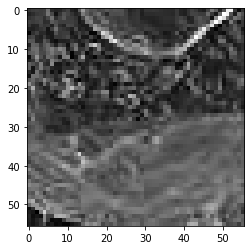

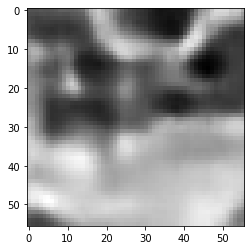

41.00465230643749

 next


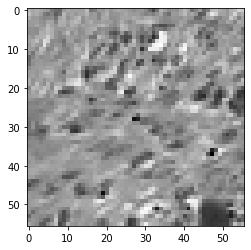

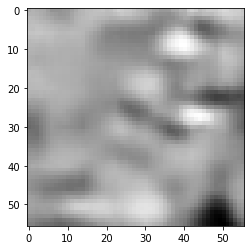

32.64575444161892

 next


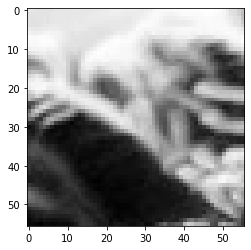

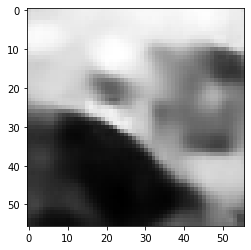

113.74194145202637

 next


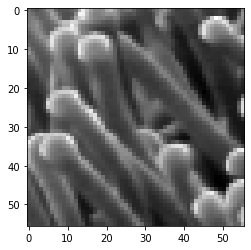

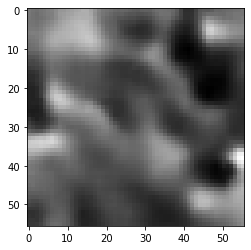

32.47002527117729

 next


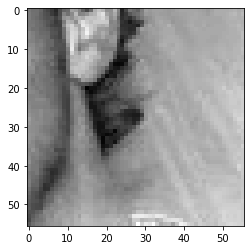

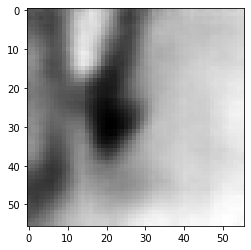

17.938689216971397

 next


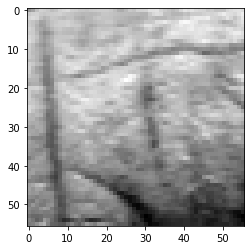

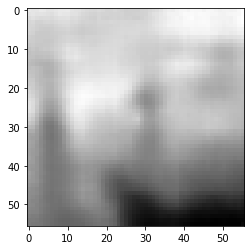

28.54490239173174

 next


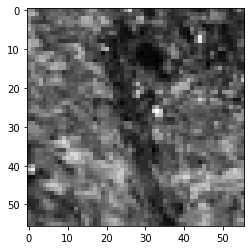

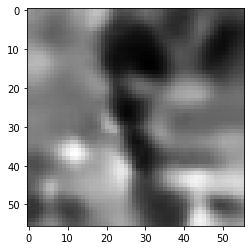

47.650476694107056

 next


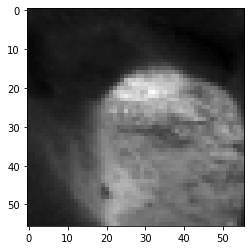

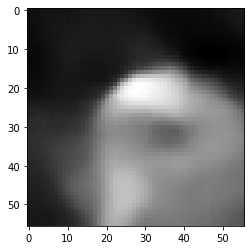

50.496881157159805

 next


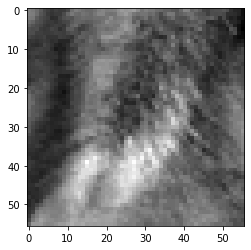

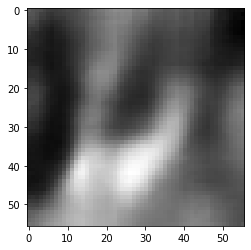

21.6616078466177

 next


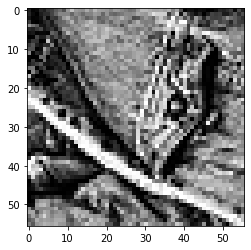

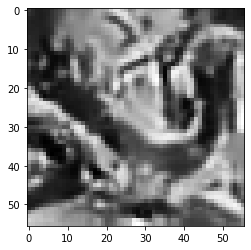

93.34895253181458

 next


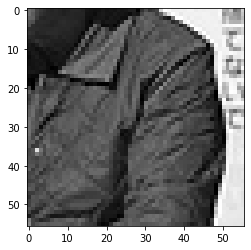

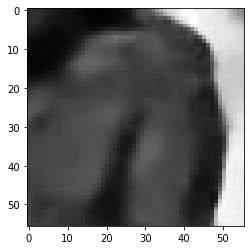

82.6066629588604

 next


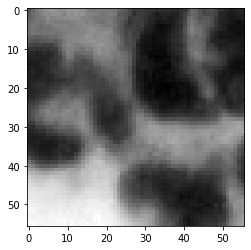

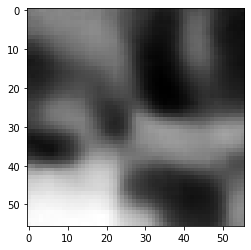

37.36461862921715

 next


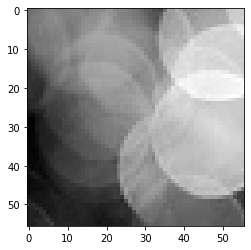

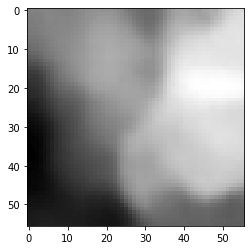

76.10266596078873

 next


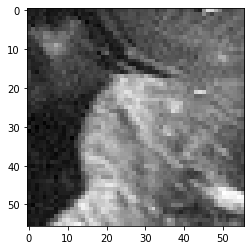

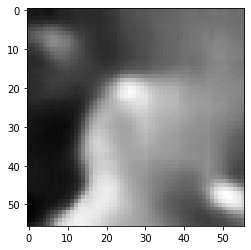

29.476403407752514

 next


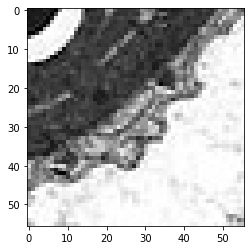

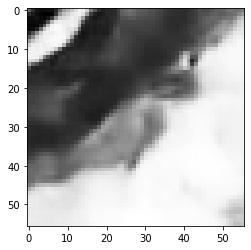

99.36363458633423

 next


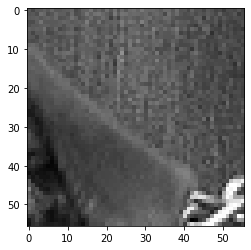

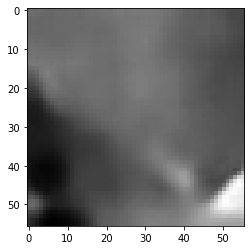

36.057389974594116

 next


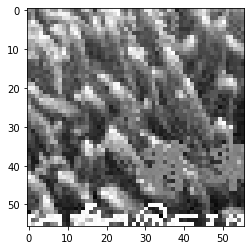

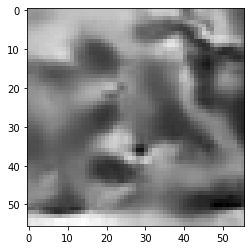

58.08837600052357

 next


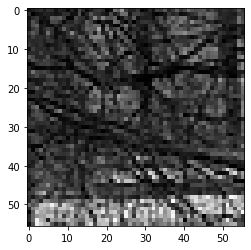

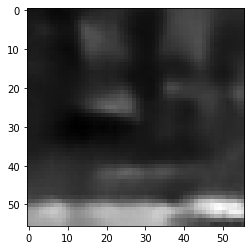

54.87651474773884

 next


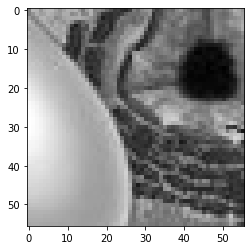

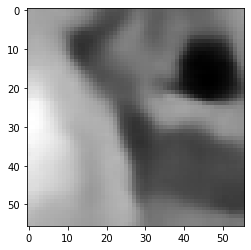

71.79380357265472

 next


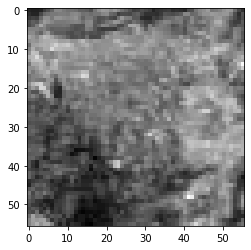

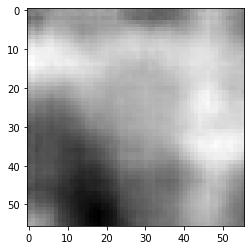

13.64187978208065

 next


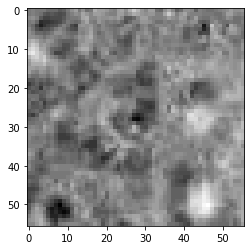

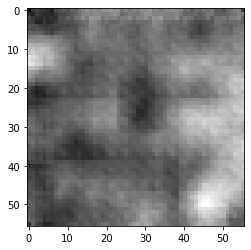

4.776282906532288

 next


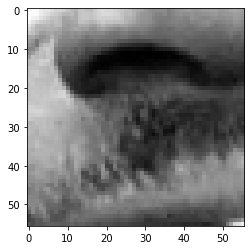

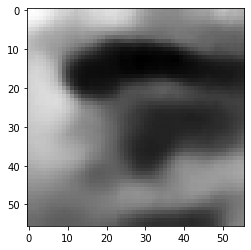

50.42273573577404

 next


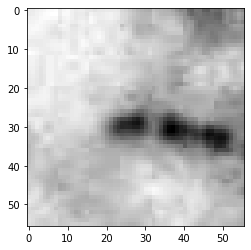

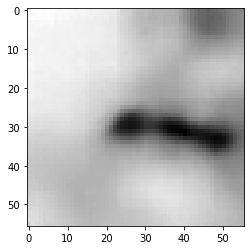

26.14537674933672

 next


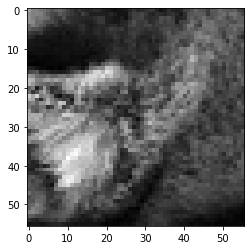

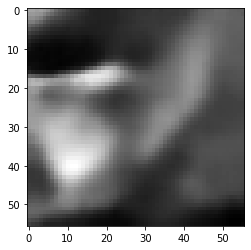

41.65519639849663

 next


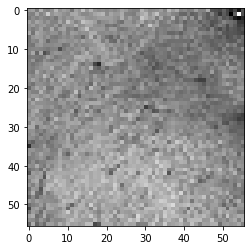

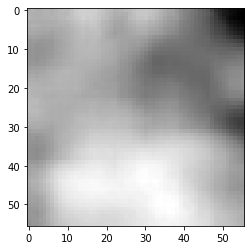

30.238967388868332

 next


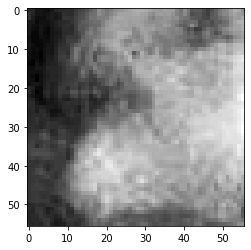

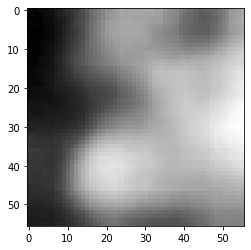

22.070123925805092

 next


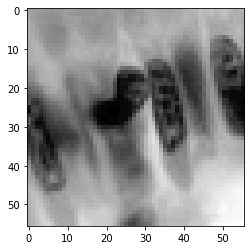

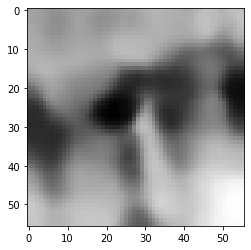

59.303676187992096

 next


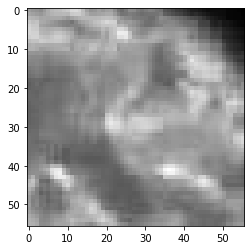

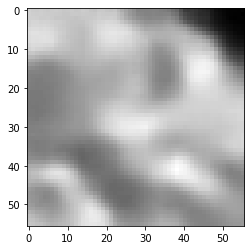

29.416438825428486

 next


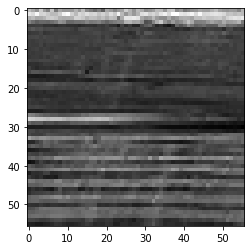

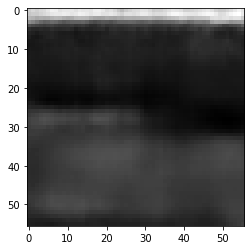

40.24933263659477

 next


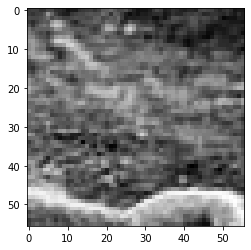

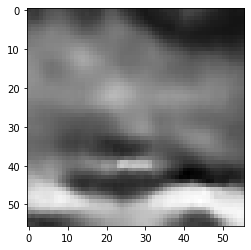

39.83865067362785

 next


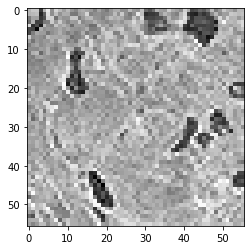

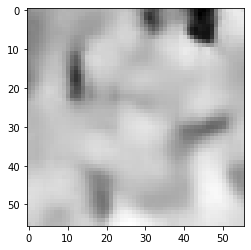

42.19650015234947

 next


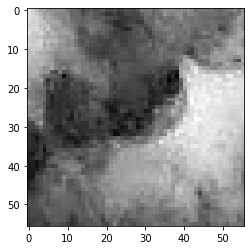

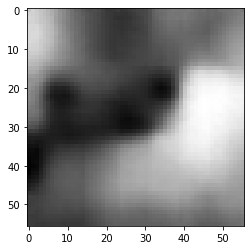

29.780478291213512

 next


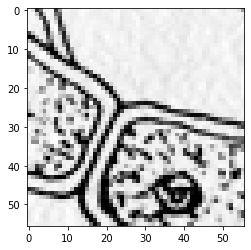

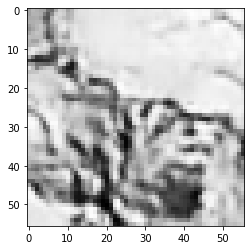

96.67664676904678

 next


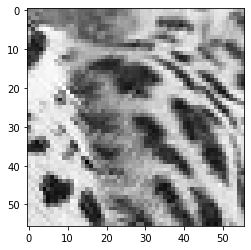

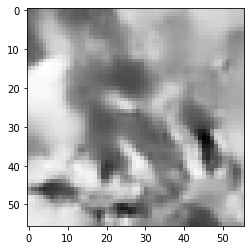

69.35862064361572

 next


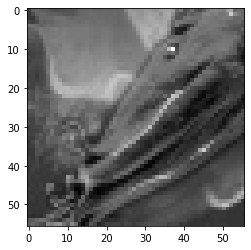

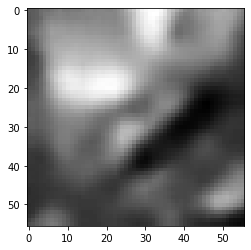

34.388717114925385

 next


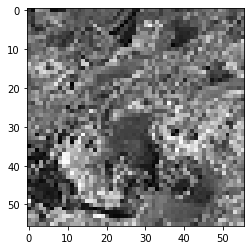

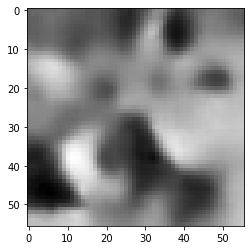

55.150833427906036

 next


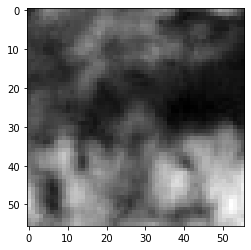

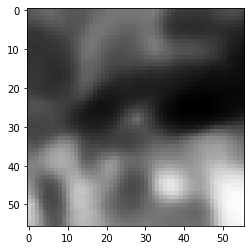

47.64510378241539

 next


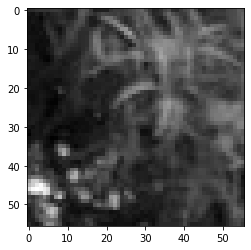

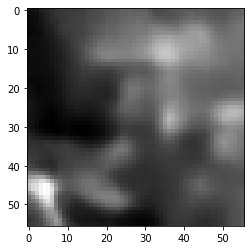

28.96234419196844

 next


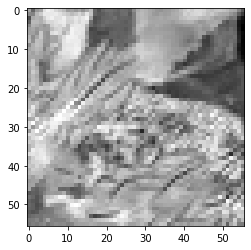

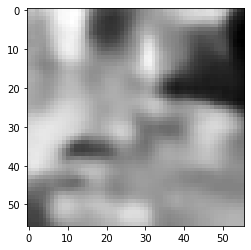

52.071816846728325

 next


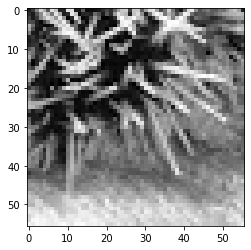

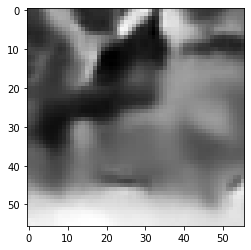

76.7950040102005

 next


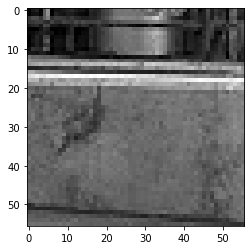

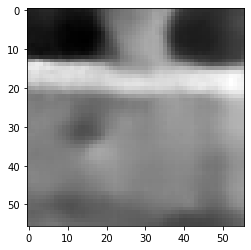

44.47874128818512

 next


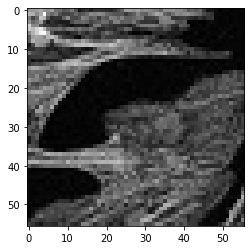

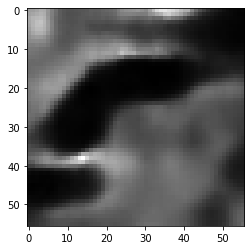

32.16320313513279

 next


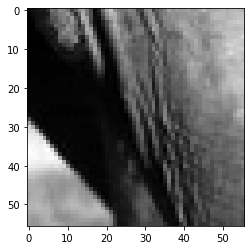

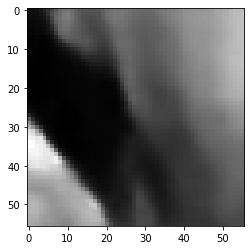

59.33632403612137

 next


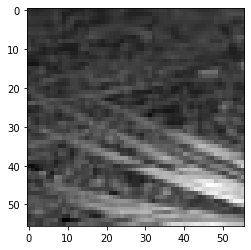

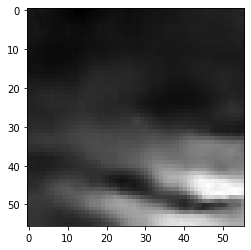

32.63095423579216

 next


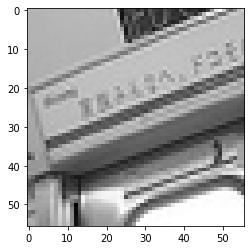

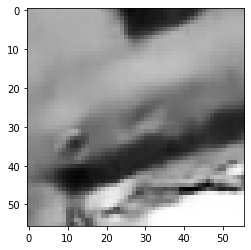

71.03252962231636

 next


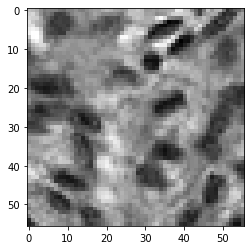

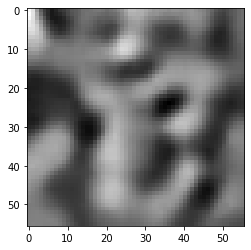

41.651267409324646

 next


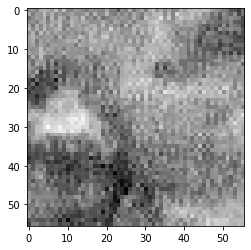

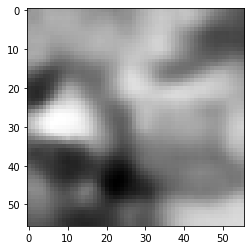

49.37874175608158

 next


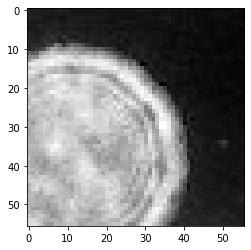

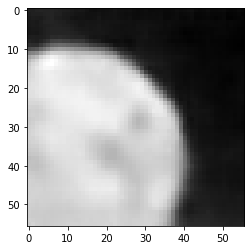

66.16378247737885

 next


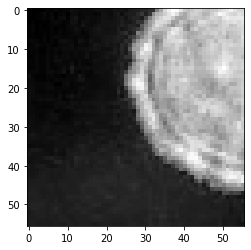

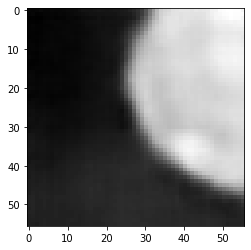

58.493191078305244

 next


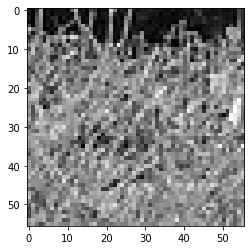

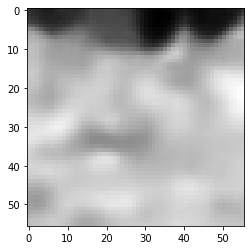

60.5539420992136

 next


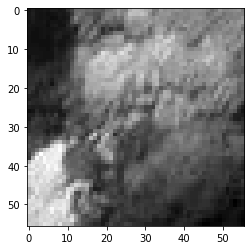

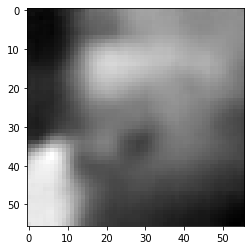

28.119859099388123

 next


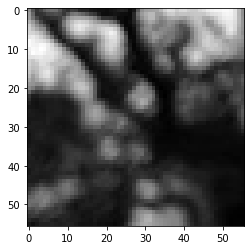

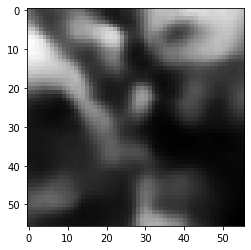

59.937672168016434

 next


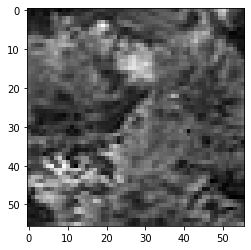

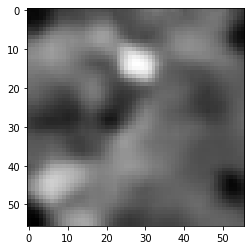

30.43307237327099

 next


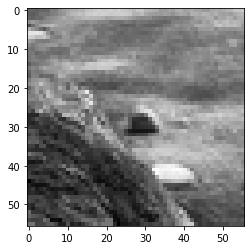

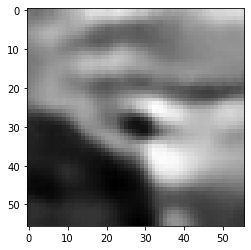

54.756897166371346

 next


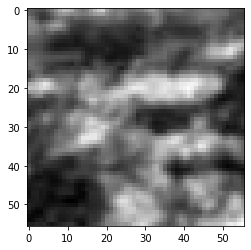

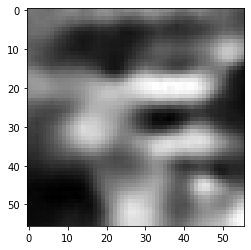

31.1895851790905

 next


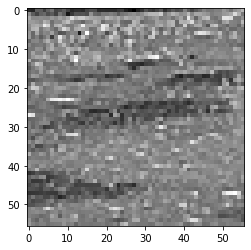

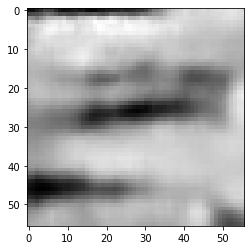

33.56544189155102

 next


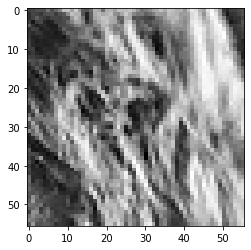

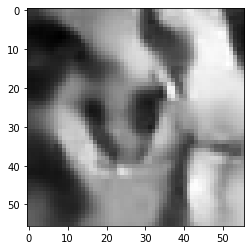

74.07213091850281

 next


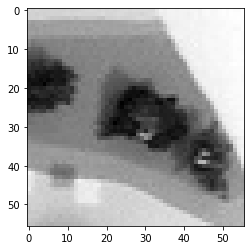

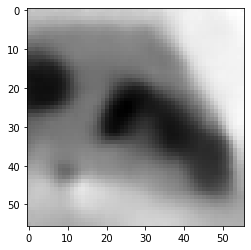

59.598471969366074

 next


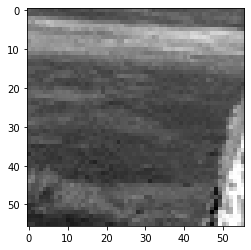

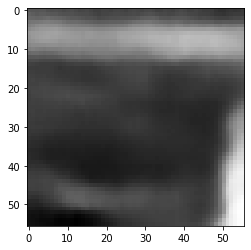

50.78539967536926

 next


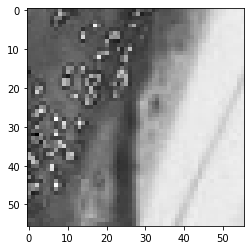

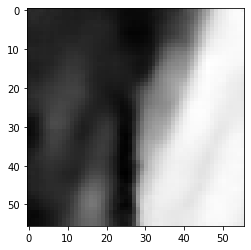

76.31949752569199

 next


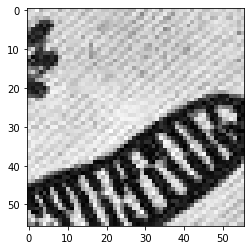

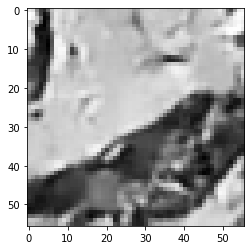

93.04244577884674

 next


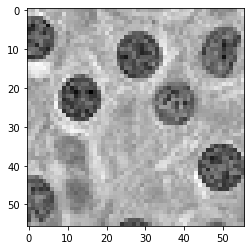

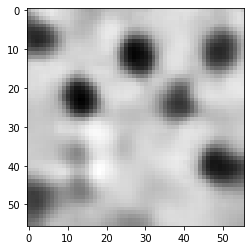

50.24012513458729

 next


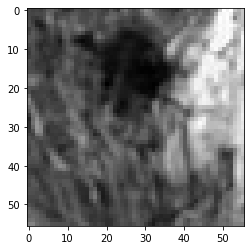

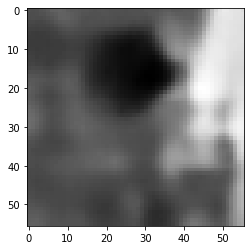

68.61252307891846

 next


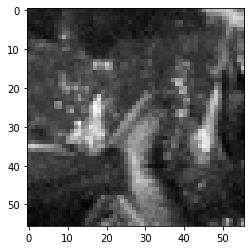

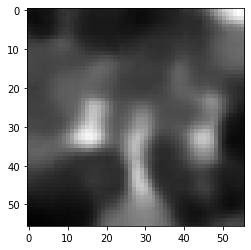

34.314241111278534

 next


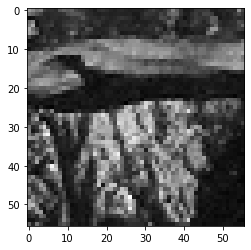

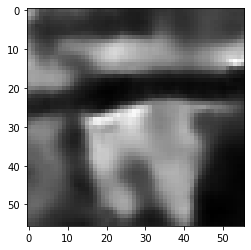

60.28765618801117

 next


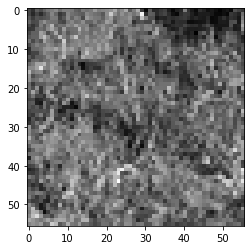

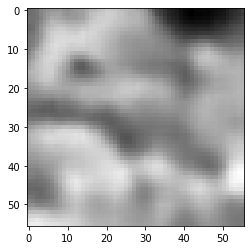

31.929234489798546

 next


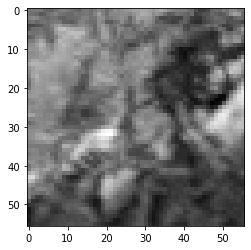

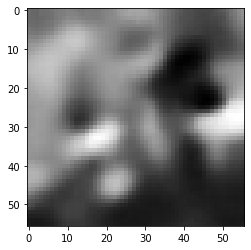

40.198210179805756

 next


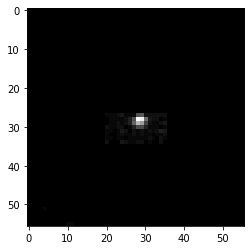

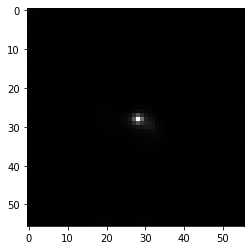

1.3364927843213081

 next


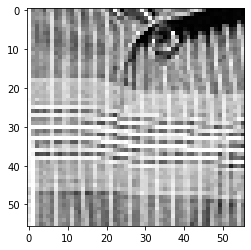

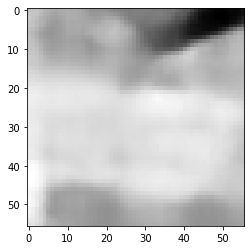

71.6133588552475

 next


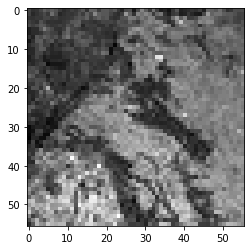

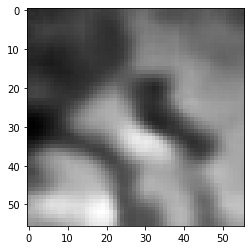

30.491851419210434

 next


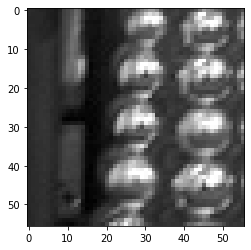

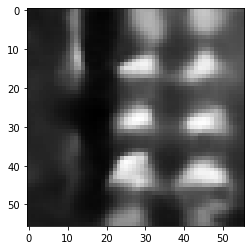

74.55563217401505

 next


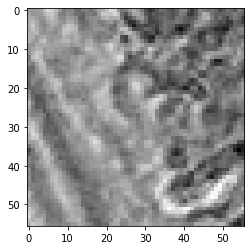

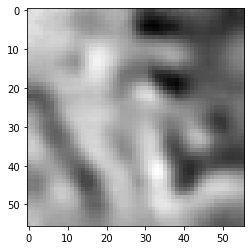

30.486588701605797

 next


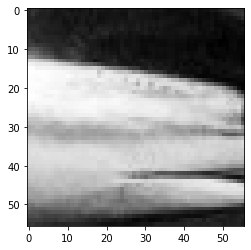

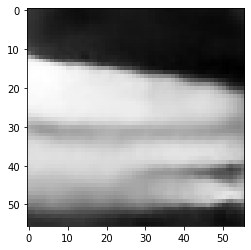

100.64863443374634

 next


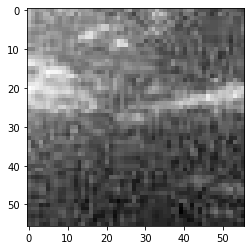

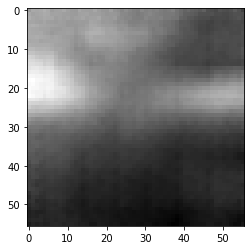

10.89465094730258

 next


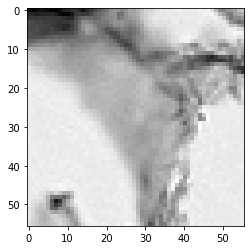

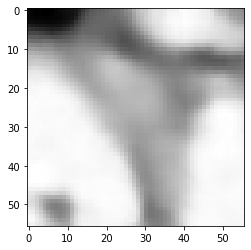

60.71665316820145

 next


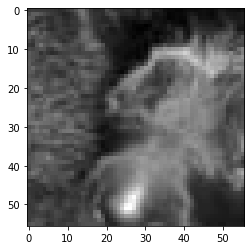

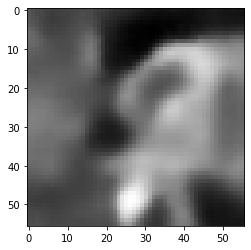

46.11013434827328

 next


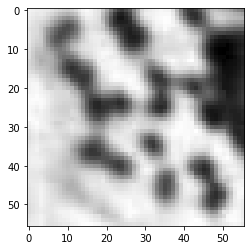

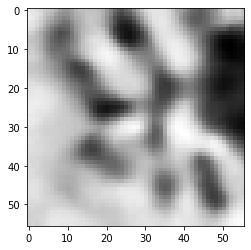

49.72398743033409

 next


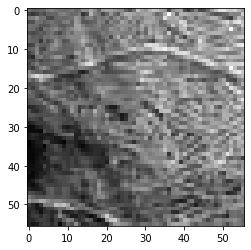

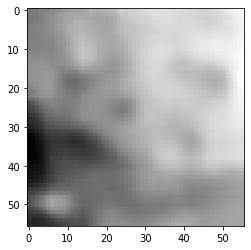

37.80206635594368

 next


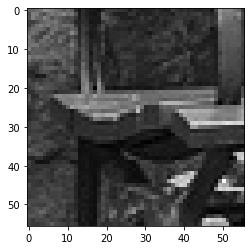

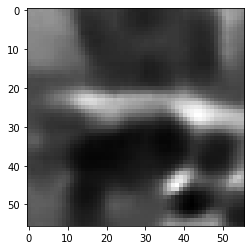

35.77527031302452

 next


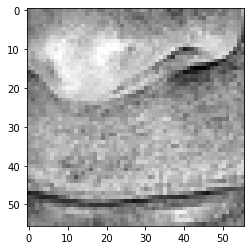

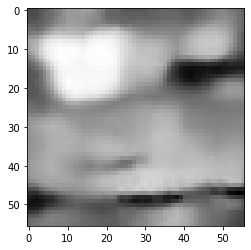

47.34640561044216

 next


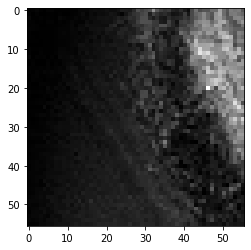

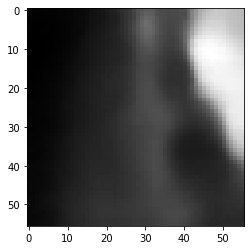

49.16362389922142

 next


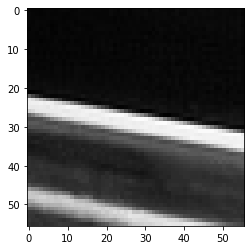

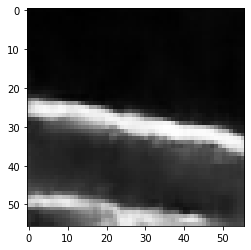

92.93649226427078

 next


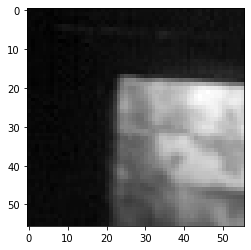

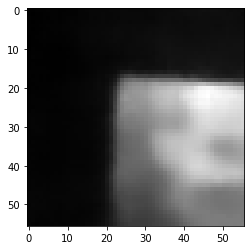

68.13608184456825

 next


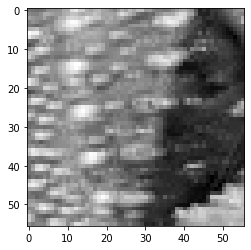

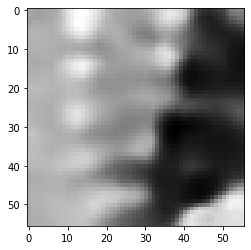

56.04606918990612

 next


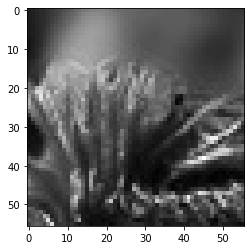

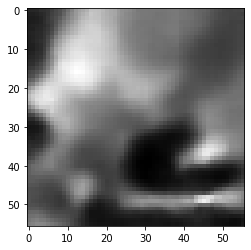

34.538767263293266

 next


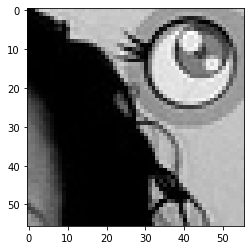

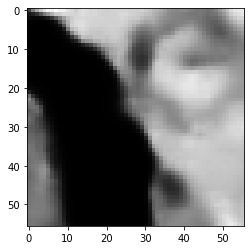

89.86044332385063

 next


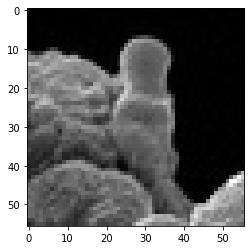

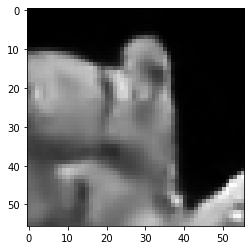

84.61901977658272

 next


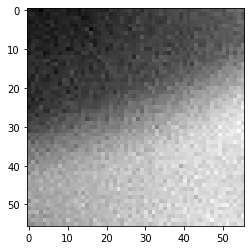

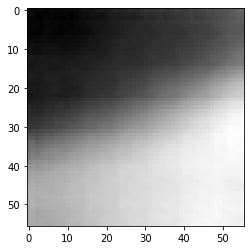

22.407671213150024

 next


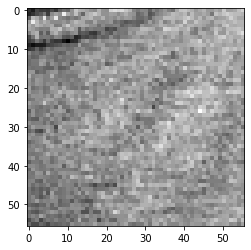

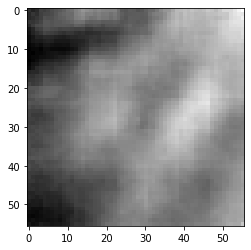

9.817485697567463

 next


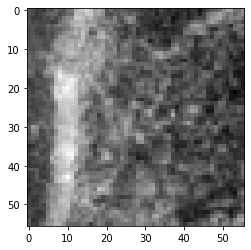

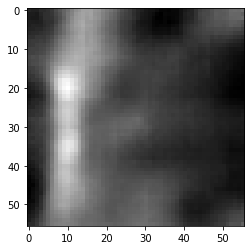

13.390455823391676

 next


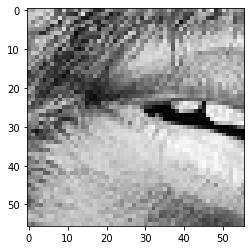

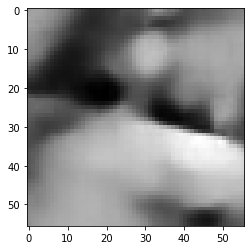

67.19298765063286

 next


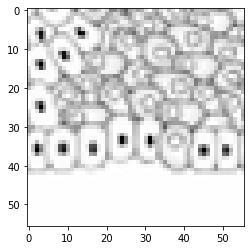

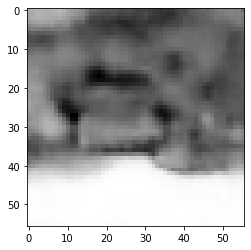

46.69080778956413

 next


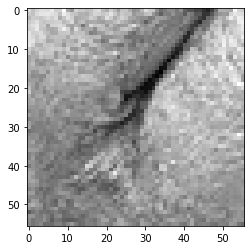

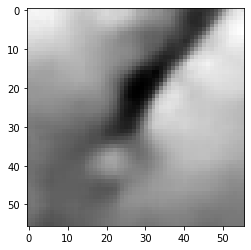

41.62072844803333

 next


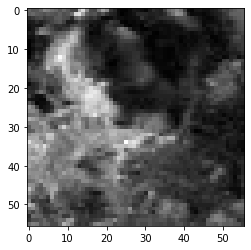

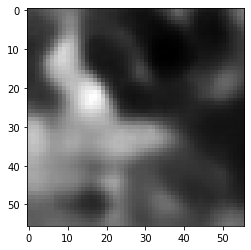

39.56464737653732

 next


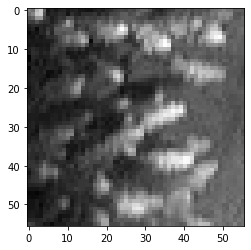

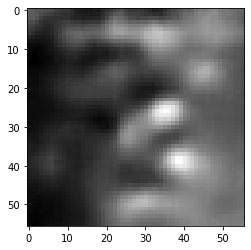

21.599733866751194

 next


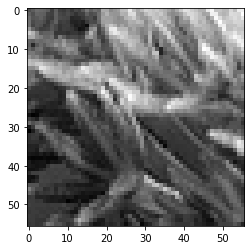

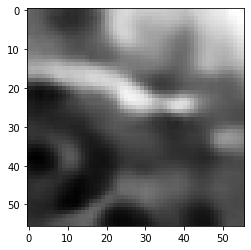

65.92506408691406

 next


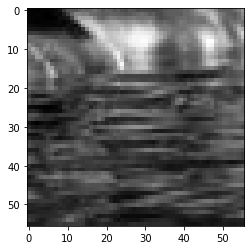

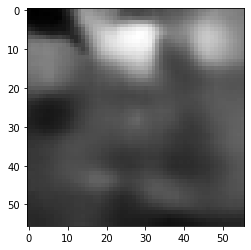

41.7920308560133

 next


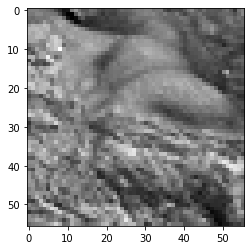

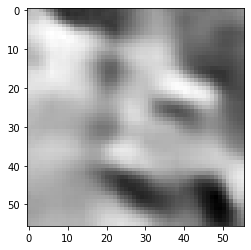

32.48775132000446

 next


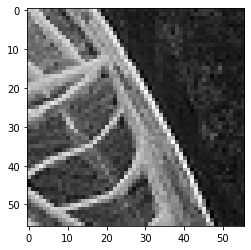

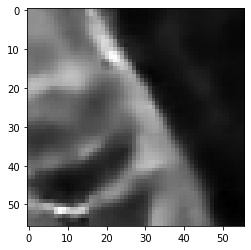

66.28187254071236

 next


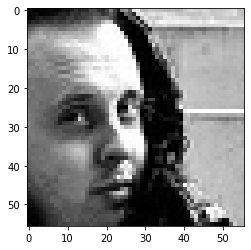

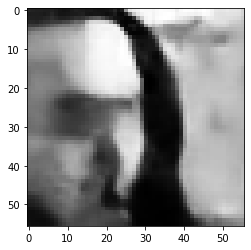

112.09595337510109

 next
0.1946264013648033


In [26]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [16]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())

# history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

# model_version = "0.0.0.5"
# vae.save_weights(base_dir + '/vae_' + model_version + '.h5')
